<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapitel 4: Supervised Learning

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
print(np.__version__)

import sklearn
print(sklearn.__version__)

1.21.4
1.0.2


Mit Supervised Learning (überwachtem Lernen) bezeichnet man ein vom Menschen gesteuertes Lernen. Dabei wird ein System mit bekannten Daten trainiert, und dieses Wissen wird dann auf bisher nicht bekannte Daten angewendet. Insbesondere soll eine mathematische Funktion gelernt werden, die Features als Eingabe bekommt und die entsprechenden Labels als Ausgabe haben soll. Die Parameter dieser Funktion sollen so optimiert werden, dass die bekannten Daten möglichst gut wiedergegeben werden, dass aber auch gleichzeitig die Labels von neuen Daten vorhergesagt werden  können.

## Lineare Regression auf Boston House Prices

Als erstes Beispiel nehmen wir den bekannten Boston-HousingDatensatz (https://archive.ics.uci.edu/ml/machine-learning-databases/
housing/), der die Immobilienpreise verschiedener Vororte Bostons auflistet.

Der Datensatz enthält neben den Preisen 13 weitere Attribute der Häuser bzw. der Nachbarschaft, in der sich diese befinden. In unserem Beispiel wollen wir die Relation der Immobilienpreise (medianer Wert pro Bezirk) zu der durchschnittlichen Zimmeranzahl untersuchen.

In [1]:
# Importiere den Datensatz von sklearn.datasets
import sklearn.datasets as data

boston = data.load_boston()

c:\tools\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.


In [9]:
# Überprüfe die Dimension der Daten und des Targets
boston.data.shape, boston.target.shape

((506, 13), (506,))

In [2]:
# Schaue dir die Beschreibung an
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [10]:
# Die sechste Spalte in boston.data gibt die durchschnittliche Zimmeranzahl an. 
# Wir speichern Features und Labels in gewohnter Weise in den Variablen X und y
X = boston.data[:, 5:6]
y = boston.target

Text(0, 0.5, 'Preis ($1000)')

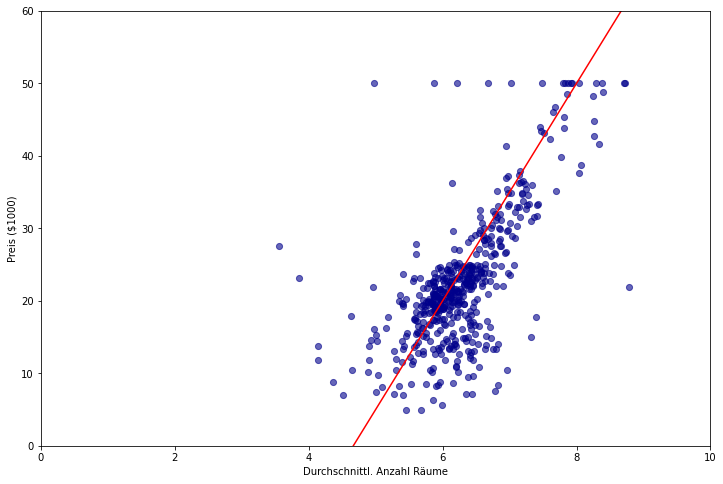

In [11]:
# Wenn wir den Preis (target) gegen die Zimmeranzahl auftragen, können wir eine gewisse Tendenz erkennen.
# Nutze matplotlib.pyplot
# Im Buch Abbildung 4-1
import matplotlib.pyplot as plt
import numpy as np

a = 15
b = -70
lx = np.arange(4, 10)
lguess = a*lx + b

plt.figure(figsize=(12,8))
plt.plot(lx, lguess, c='red')
plt.scatter(X, y, marker='.', s=150, alpha=0.6, color='darkblue')
plt.xlim(0, 10) 
plt.ylim(0, 60)
plt.xlabel('Durchschnittl. Anzahl Räume')
plt.ylabel('Preis ($1000)')

Wir hegen den Verdacht, dass die Relation mehr oder weniger linear ist. Mit dem Auge können wir sogar ganz grob eine Linie erraten. Die Gerade
$y = 15 · X – 70$ (rote Linie) in der Abbildung scheint ein gute erste Schätzung zu sein.

Ist das aber die »beste« Gerade? Oder gibt es bestimmte Methoden, wie man die »passendste« Gerade finden kann? Genau darum geht es beim Machine Learning: Wie findest du möglichst automatisch bzw. mithilfe eines selbstlernenden Algorithmus die optimale Lösung zu einem Problem? Und da lineare Regression ein schon lange bekanntes und sehr gut verstandenes Problem ist, wollen wir dich Schritt für Schritt durch diese erste Aufgabe führen.

Eine Gerade in der x-y-Ebene kann mathematisch folgendermaßen formuliert werden:
$$ y=ax+b$$

wobei $y$ in unserem Beispiel den Preis darstellt, der in einer bestimmten Relation zu $x$, der Zimmeranzahl, steht. In der MachineLearning-Sprache sind die $y$-Werte die Labels und die $x$-Werte die Features. $a$ und $b$ sind die Parameter des linearen Regressionsmodells. In unserem Fall kann man $a$ als die Steigung und $b$ als den $y$-Schnittpunkt grafisch interpretieren.

## Loss-Funktion

Es gibt verschiedene Möglichkeiten, wie du dem Lernalgorithmus mitteilst, welche die »beste« Kurve (in diesem Fall eine Gerade) sein
soll. Dieser Algorithmus soll die optimalen Parameter selbst herausfinden, d.h. »erlernen«. 

Zu dem Zweck definieren wir eine sogenannte Loss-Funktion (manchmal auch Cost- oder Error-Funktion genannt). Wir zeigen dir erst einmal so eine Funktion $L$ (für Loss) und erläutern sie dann Schritt für Schritt:
$$ L = \sum \left(y_i^{\text{true}} - y_i^{\text{pred}}\right)^2 = \sum \left[y_i^{\text{true}} - (a\cdot x_i +b)\right]^2 $$

Wir bilden die Summe aller Abweichungen des tatsächlichen $y$-Werts ($y_i^{\text{true}}$) von dem $y$-Wert ($y_i^{\text{pred}}$), den unsere Geradenfunktion vorhersagt. Die Vorhersage $y_i^{\text{pred}}$ können wir durch die Geradenfunktion von oben ersetzen, damit wir außer $a$ und $b$ keine weiteren Unbekannten in unserer Formel haben. Den wahren Wert $y_i^{\text{true}}$ kennen wir aus dem target-Feld unseres Datensatzes.

Mit dieser Funktion sucht der Lernalgorithmus der linearen Regression diejenigen Parameter $a$ und $b$, die die Summe aller Abweichungen minimiert. Das Quadrat benutzen wir, weil wir die Abweichungen immer positiv zählen, außerdem werden Punkte, die weit weg von der Geraden liegen, besonders stark gewichtet. Das heißt, größere Abweichungen tragen im erhöhten Maß zum Gesamtfehler bei.

## Ordinary Least Square

Der einfachste Lernalgorithmus, der mithilfe einer solchen LossFunktion die optimalen Parameter $a$ und $b$ findet, ist die Methode
**Ordinary Least Square (OLS)** bzw. die Methode der kleinsten Quadrate. Sie ist die klassische schon seit Jahrhunderten bekannte
Methode und steht praktisch als Synonym für lineare Regression. Details zu OLS findest du z.B. in Wikipedia: https://en.wikipedia.org/wiki/Ordinary_least_squares oder https://de.wikipedia.org/wiki/Methode_der_kleinsten_Quadrate.

In [12]:
# Wir machen es uns etwas einfacher und erhalten die Lösung mithilfe der Scikit-Learn-Bibliothek:
# Wir laden das Modul LinearRegression, erzeugen eine Instanz des Regressors und 
# trainieren ihn mit unseren Daten. 
# Dazu rufen wir die fit()-Methode mit der Zimmeranzahl X auf und geben ihr auch die tatsächlichen Preise y mit:
import sklearn.linear_model as lm

lr = lm.LinearRegression() # Regressor Instanz
lr.fit(X, y) # Training des Regressors mit den Daten

LinearRegression()

In [13]:
#  Erst einmal sehen wir uns aber an, wie gut das Training funktioniert 
# hat, und zwar über den Aufruf der score()-Methode:
lr.score(X, y) # Validierung

0.48352545599133423

Die voreingestellte Metrik für die `score()`-Methode für lineare Regression ist der sogenannte **R2-Score**. Es ist ein Maß für die Güte dieses Modells. Für uns reicht es hier erst einmal, zu wissen, dass die Güte des Modells desto besser ist, je näher der Score an 1 liegt.

Mehr über die Metrik und eine ausführliche Beschreibung der Güte eines Modells findest du in Kapitel 6, Modellvalidierung. Darin werden wir auch darauf eingehen, warum es für die Validierung des Modells günstig ist, nicht die Werte zu überprüfen, die wir bereits für das Training benutzt haben. In diesem Kapitel konzentrieren wir uns aber auf die Funktionsweise der verschiedenen Methoden und validieren erst einmal auf den Trainingsdaten.

In [14]:
# Die Vorhersage des trainierten Modells für bestimmte Features
# erhält man über die predict()-Methode.
y_pred = lr.predict(X)

In [15]:
y_pred.shape

(506,)

Text(0, 0.5, 'Preis ($1000)')

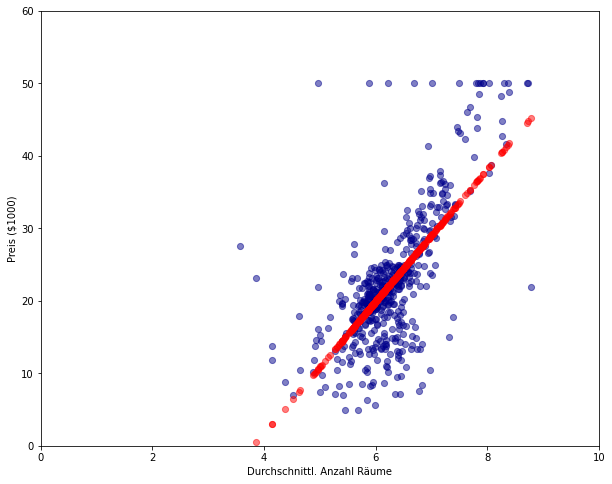

In [16]:
# In dieser Abbildung werden die wahren Werte (blau) mit der Vorhersage aus der predict()-Methode (rot) für alle Trainingsdaten verglichen.
# Im Buch Abbildung 4-2
plt.figure(figsize=(10,8))
plt.scatter(X, y, marker='.', s=150, alpha=0.5, color='darkblue')
plt.scatter(X, y_pred, marker='.', s=150, alpha=0.5, color='red')
plt.xlim(0, 10)
plt.ylim(0, 60)
plt.xlabel('Durchschnittl. Anzahl Räume')
plt.ylabel('Preis ($1000)')

## Grundlegende API von Scikit-Learn (Sklearn)

Das Praktische an der Scikit-Learn-Bibliothek ist, dass alle Regressor- und Klassifikatorklassen im Großen und Ganzen die gleiche
API besitzen. Das wird im Folgenden noch mal zusammengefasst:

Zunächst erzeugst du eine Instanz einer Klassifikator- oder Regressionsklasse, z.B.:

```Python
import sklearn.linear_model as lm
lr = lm.LinearRegression()
```

Das Training der Daten $X$ mit den Labels $y$ wird immer über die Methode `fit()`, eventuell mit zusätzlichen Optionen, aufgerufen:

```Python
lr.fit(X, y)
```

Die Güte des Modells kann man mit der Methode `score()` berechnen:

```Python
lr.score(X, y)
```

Dabei solltest du beachten, dass bestimmte Score-Methoden voreingestellt sind. In der Regel liefern sie einen Wert zwischen 0 und
1, wobei ein großer Wert für hohe Güte steht. Für manche Probleme und Daten sind eventuell andere Score-Definitionen (auch Metriken genannt) aussagekräftiger. 

Die Voraussage des trainierten Modells für neue Daten rufst du mit der Methode `predict()` auf:

```Python
lr.predict(X)
```

## Stochastic Gradient Descent

Stochastic Gradient Descent (SGD) heißt ein Algorithmus, der mithilfe einer vorher definierten Loss-Funktion die optimalen Parameter $a$ und $b$ finden soll. Dieser Optimierungsalgorithmus wird heutzutage sehr häufig in Lernalgorithmen angewendet. Mit SGD kann man sehr gut die Art und Weise veranschaulichen, wie viele moderne Machine-Learning-Algorithmen funktionieren.

Für unser Boston-Housing-Problem starten wir mit irgendwelchen zufällig ausgewählten Parametern $a$ und $b$. Im nächsten Schritt hangeln wir uns an der durch die Loss-Funktion beschriebenen Kurve zum Minimum hinunter (siehe Abbildung), indem wir die Steigung der Kurve durch die Ableitung der Funktion an den aktuellen Parameterwerten berechnen. Wenn etwas Negatives herauskommt, gehen wir nach rechts. Kommt etwas Positives raus, gehen wir nach links.

Die Ableitung oder das Differential einer Funktion beschreibt so etwas wie die Veränderung oder die Tendenz der Funktion bzw. der Kurve. Ist die Ableitung an einem bestimmten Punkt positiv, wird die Funktion für größere $x$ größer und für kleinere $x$ kleiner. Umgekehrt, bei einem negativen Ableitungswert, wird die Funktion für größere $x$ kleiner und für kleinere $x$ größer. Die Ableitung kann man grafisch auch als Steigung der Tangente an dem jeweiligen Punkt der Kurve darstellen. Tangentenhälften einer Loss-Funktion für einen gegebenen Datensatz, die in Richtung niedrigerer Werte zeigen, sind in der folgenden Abbildung dargestellt.

<table>
<tr>
<td><img src="images/5-7.png"></td>
<td><img src="images/5-11.png"></td>
</tr>
<tr>
<td><img src="images/5-12.png"></td>
<td><img src="images/5-13.png"></td>
<td><img src="images/5-14.png"></td>
</tr>
<tr>
<td><img src="images/5-17.png"></td>
</tr>
</table>

Sollte die Ableitung 0 sein, haben wir unser Ziel erreicht, wir sind am Minimum unserer Loss-Funktion angelangt. Genauer gesagt, könnte es auch nur ein sogenanntes lokales Minimum sein oder sogar ein (lokales) Maximum. Lokale Minima und Maxima kannst du durch unterschiedliche
Strategien vermeiden. Eine Maßnahme ist z.B., die Schrittweite (die **Learning Rate**), mit der wir nach links oder rechts gehen, geschickt
dynamisch anzupassen (siehe unten).  Bei der Stochastic-Gradient-Descent-Methode wird diese iterative Minimierung möglichst effizient ausgeführt. Sie wird sehr häufig auch bei anderen Lernalgorithmen, z.B. bei neuronalen Netzen, die wir in Kapitel 7, Neuronale Netze und Deep Learning, beschreiben, benutzt.

Der Begriff Gradient steht für eine mehrdimensionale Ableitung in  eine bestimmte Richtung. In einer Dimension gibt es nur »rechts«
oder »links«. Bei drei Dimensionen gäbe es z.B. auch »vorne«, »hinten«, »oben«, »unten« oder sogar eine bestimmte Kombination daraus. Descent ist der »Abstieg«. Beides zusammen bedeutet in unserem Fall also die Richtung, in die man gehen muss, um zum Minimum der Funktion zu gelangen.

Nun müssen wir uns überlegen, wie wir mit dieser Information unsere beiden Parameter $a$ und $b$ schrittweise in Richtung des Minimums anpassen. Den oben erläuterten Gradienten, also die mehrdimensionale Ableitung von $L$, beschreiben wir wie in der Mathematik üblich mit $\nabla L$. Diesen multiplizieren wir mit der ebenfalls bereits erwähnten Learning Rate $\eta$, also dem Faktor, der bestimmt, wie stark die Änderung pro Iteration sein soll. Wir erhalten dann pro Schritt eine Korrektur von, die wir von den bisherigen Werten abziehen müssen.

Wenn wir alle Parameter, auch Gewichte genannt, in einen Vektor $w$ zusammenfassen, lautet die Update-Regel für einen Iterationsschritt somit:

$w_{i+1} = w_i - \eta \cdot \nabla L$

In unserem eindimensionalen Regressionsfall ist $w = (a, b)$, da wir bei unserer Geradengleichung ja die Parameter für die Steigung und
die Verschiebung herausfinden wollen. Hier die Geradengleichung noch einmal zur Erinnerung:

$y = a\cdot x + b$

Bei jeder Iteration werden $a$ und $b$ nach dieser Vorschrift verändert, bis die Änderung null oder nur noch sehr gering ist.

Die Learning Rate ist ein sehr wichtiger Parameter des Lernalgorithmus. Stellt man ihn zu klein ein, wird es unter Umständen sehr
lange dauern, bis wir auch nur in die Nähe des Minimums gelangen (dabei spricht man oft auch von »konvergieren«). Stellt man die
Learning Rate zu groß ein, besteht die Gefahr, dass der Algorithmus immer wieder über das Minimum hinwegspringt und wir nie eine
zufriedenstellende Lösung finden. Die Learning Rate richtig zu tunen, ist schwierig. Eine mögliche Strategie ist es, mit einer relativ großen Learning Rate zu starten und sie dann stetig immer kleiner werden zu lassen. Weitere sehr clevere Algorithmen (z.B. RmsProp oder Adam) berücksichtigen die Gradienten voriger Iterationsschritte und ermitteln daraus eine Richtung, die schneller konvergiert. Wir werden die Methoden in diesem Buch zwar nicht besprechen, aber du kannst dir mehr Informationen z.B. hier beschaffen: http://sebastianruder.com/optimizinggradient-descent/.

Wenn du viele Daten hast und viele Features auswerten möchtest, kann die Berechnung des Gradienten sehr lange dauern oder sehr
viel Speicherplatz beanspruchen, weil dafür alle Daten mit allen Feature-Dimensionen im Speicher gehalten werden müssen. Deshalb ist es eine gute Strategie, immer nur einen Datenpunkt auszuwerten und dementsprechend die Parameter $a$ und $b$ zu aktualisieren. Wenn man das auf diese Weise Schritt für Schritt für jeden einzelnen Datenpunkt macht, kommt man am Ende auf ein sehr ähnliches Ergebnis, als hätte man alle Daten auf einmal berechnet. Dies ist eine sogenannte **stochastische Annäherung**, die manchmal schneller konvergiert. Auf jeden Fall beansprucht sie weniger Speicherressourcen (für jede Berechnungsiteration muss nur ein Datenpunkt zum selben Zeitpunkt im Speicher liegen). Es gibt noch eine Mittellö-
sung, die sogenannte **Mini-Batch-Gradient-Descent-Methode**, bei der man das Update immer nur für z.B. 10 oder 100 Datensätze durchführt.

In [17]:
# Trainiere einen Regressor mit SGD auf unseren Daten
lr = lm.SGDRegressor(loss="squared_error")
lr.fit(X, y)

SGDRegressor()

In [18]:
# Bestimme den Score für die Daten
lr.score(X, y)

0.37383628784524103

Text(0, 0.5, 'Preis ($1000)')

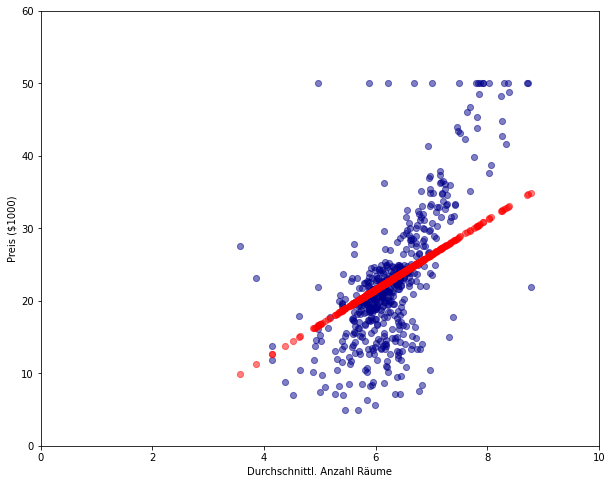

In [19]:
# Visualisiere die Daten plus die Regressionsgerade
# Im Buch Abbildung 4-5
plt.figure(figsize=(10, 8))
pred = lr.predict(X)
plt.scatter(X, y, marker='.', s=150, alpha=0.5, color='darkblue')
plt.scatter(X, pred, marker='.', s=150, alpha=0.5, color='red')
plt.xlim(0, 10)
plt.ylim(0, 60)
plt.xlabel('Durchschnittl. Anzahl Räume')
plt.ylabel('Preis ($1000)')

Warum ist das Ergebnis schlechter als mit der Klasse `LinearRegression`?

Der SGD-Algorithmus beendet die Optimierung, wenn sich der Fehler für eine Reihe von Durchläufen nicht nennenswert ändert. Dieser Wert ist auf $1e-3$ voreingestellt und für uns zu hoch. Wir setzen diesen Wert außer Kraft – damit durchlaufen wir die voreingestellten 1.000 Durchläufe und bekommen einen Score nahe an 0,5:

In [20]:
# Wie viele Iterationen hat SGD gemacht?
lr.n_iter_

36

In [21]:
# n_iter wird nicht mehr unterstützt, dies ist das Äquivalent 
# alte Version (im Text der ersten Auflage beschrieben): https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.SGDRegressor.html
# neue Version (im Text der zweiten Auflage beschrieben): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
# Passe den SGD Regressor so an, dass er weiter optimiert
#lr = lm.SGDRegressor(n_iter=10000)
lr = lm.SGDRegressor(loss="squared_error", tol=None)

lr.fit(X, y)

SGDRegressor(tol=None)

In [22]:
# Bestimme erneut die Anzahl der Iterationen
lr.n_iter_

1000

In [23]:
# Bestimme den Score für unsere Daten
lr.score(X, y)

0.47825817501258694

Text(0, 0.5, 'Preis ($1000)')

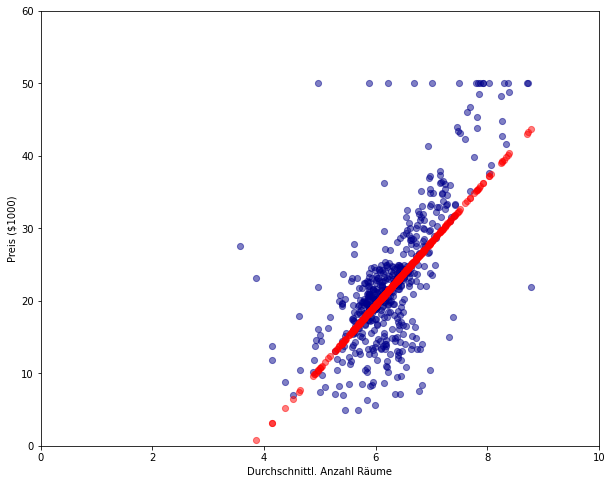

In [24]:
# Visualisiere erneut die Ergebnisse des SGD Regressors
# Im Buch Abbildung 4-6

plt.figure(figsize=(10, 8))
pred = lr.predict(X)
plt.scatter(X, y, marker='.', s=150, alpha=0.5, color='darkblue')
plt.scatter(X, pred, marker='.', s=150, alpha=0.5, color='red')
plt.xlim(0, 10)
plt.ylim(0, 60)
plt.xlabel('Durchschnittl. Anzahl Räume')
plt.ylabel('Preis ($1000)')

Das war schon unser erstes Machine-Learning-Beispiel, genauer gesagt, das erste Regressionsmodell. Als Nächstes wollen wir mit dir
ein Klassifikationsmodell erstellen.

In [ ]:
# Übung: Vergleiche verschiedene Loss-Funktions für SGD

## Logistische Regression

Regression und Klassifikation scheinen auf den ersten Blick ganz unterschiedliche Problemstellungen zu sein. Auf den zweiten Blick
gibt es aber einige Gemeinsamkeiten, die wir uns zunutze machen können. Um die Beziehung zwischen logistischer und linearer Regression zu veranschaulichen, erzeugen wir zunächst einen neuen Regressionsdatensatz mit 300 zufällig angeordneten Datenpunkten.

Text(0, 0.5, 'y')

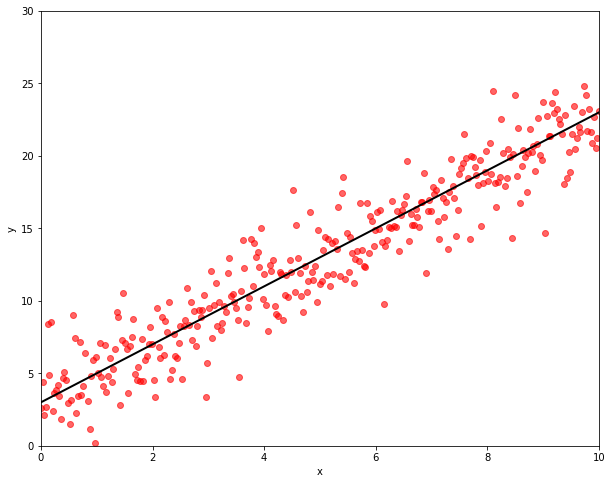

In [5]:
# In der Abbildung  ist das Label y gegen das Feature x aufgetragen,
# und die berechnete Regressionsgerade ist in Schwarz eingezeichnet
# Im Buch Abbildung 4-7
import numpy as np
import matplotlib.pylab as plt

def line(a, b, x):
    return a*x + b

x = np.linspace(0, 10)
a = 2
b = 3
y = line(a, b, x)

size = 333
x_sample = np.linspace(0, 10, size)
y_sample = a * x_sample + b + np.random.normal(loc=0, scale=2, size=size)

plt.figure(figsize=(10,8))
plt.scatter(x_sample, y_sample, marker='o', alpha=0.6, c='r')
plt.plot(x, y, c='k', lw=2.)
plt.xlim(0, 10)
plt.ylim(0, 30)
plt.xlabel('x')
plt.ylabel('y')

In der folgenden Abbildung betrachten wir nun ein Klassifikationsproblem. Es sind zwei verschiedene Klassen in Rot und Blau aufgetragen, die
man durch eine Linie (in Schwarz) mehr oder weniger gut trennen kann. Diese beiden Klassen haben wir absichtlich so generiert, dass
die trennende Linie identisch mit der Regressionsgeraden in der vorherigen Abbildung ist.

In [6]:
size = 1000
x_sample = np.linspace(0, 10, size)

y_class0 = np.array([r if r <= line(a, b, x) + 3 else -1 for x,r in zip(x_sample, 30 * np.random.uniform(size=size))])
y_class1 = np.array([r if r >= line(a, b, x) - 3 else -1 for x,r in zip(x_sample, 30 * np.random.uniform(size=size))])

Text(0, 0.5, 'y')

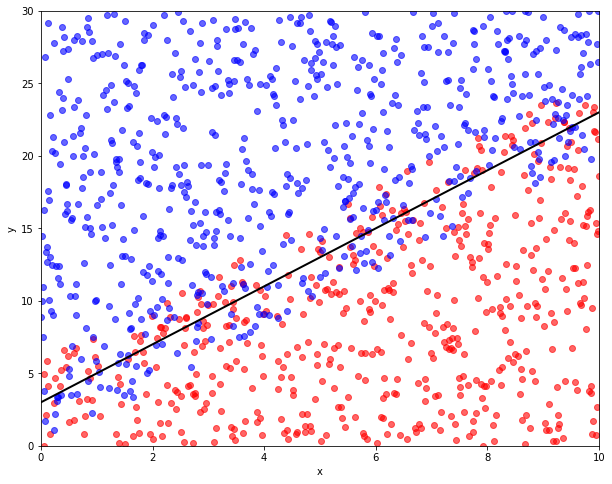

In [7]:
# Im Buch Abbildung 4-8
plt.figure(figsize=(10,8))
plt.scatter(x_sample[:len(y_class0)], y_class0, marker='o', alpha=0.6, c='r')
plt.scatter(x_sample[:len(y_class1)], y_class1, marker='o', alpha=0.6, c='b')
plt.plot(x, y, c='k', lw=2.)
plt.xlim(0, 10)
plt.ylim(0, 30)
plt.xlabel('x')
plt.ylabel('y')

Das ursprüngliche Regressionsproblem können wir nun in ein Klassifikationsproblem umformulieren: Wir suchen jetzt nicht die beste
Linie, die die Daten wiedergibt, sondern diejenige, die die beiden Klassen am besten trennt. Da es sich um ein binäres Klassifikationsproblem handelt, ordnen wir der roten Klasse das Label 1 und der blauen das Label 0 zu.

Wir bewegen uns nun entlang der ursprünglichen schwarzen Regressionsgerade und betrachten das Verhältnis von roten zu blauen
Punkten als Funktion des Abstands von der Geraden. In der folgenden Abbildung haben wir das einmal für den Abstand von zwei Einheiten von
der Geraden (graues Band) angedeutet

Text(0, 0.5, 'y')

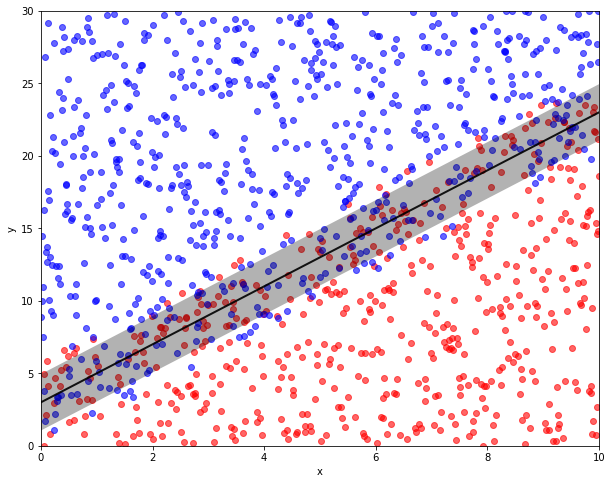

In [8]:
# Im Buch Abbildung 4-9
fig = plt.figure(1, figsize=(10, 8))

plt.scatter(x_sample, y_class0, marker='o',alpha=0.6, c='r')
plt.scatter(x_sample, y_class1, marker='o',alpha=0.6, c='b')
plt.plot(x, y, c='k', lw=50.,  alpha=0.3) # fat transparent line over opaque regression line
plt.plot(x, y, c='k', lw=2., alpha=0.9) # regression line
plt.xlim(0, 10)
plt.ylim(0, 30)
plt.xlabel('x')
plt.ylabel('y')

Nun stellen wir in der folgenden Abbildung dieses Verhältnis von roten zu blauen Punkten als Funktion des Abstands $t$ zur Geraden $p(t|x)$ dar.
In der Mitte ist die Wahrscheinlichkeit etwa 50%, entweder blaue oder rote Punkte zu finden. Je weiter man nach rechts geht, desto
größer ist die Wahrscheinlichkeit, dass man mehr rote als blaue sieht. Ganz weit rechts werden wir wahrscheinlich nur noch rote
sehen. Das Gleiche gilt umgekehrt, wenn wir links der Geraden schauen.

[ 44  44  43  58  59  68  89  91  99 114 113 117 124 140 150 146  99  65
  71  75  85  74  31   4   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  4  7 39 66 68 72 72 73 70
 77 87 78 68 62 58 58 54 53 57 43 39 34 28 23 21]


(0.0, 1.01)

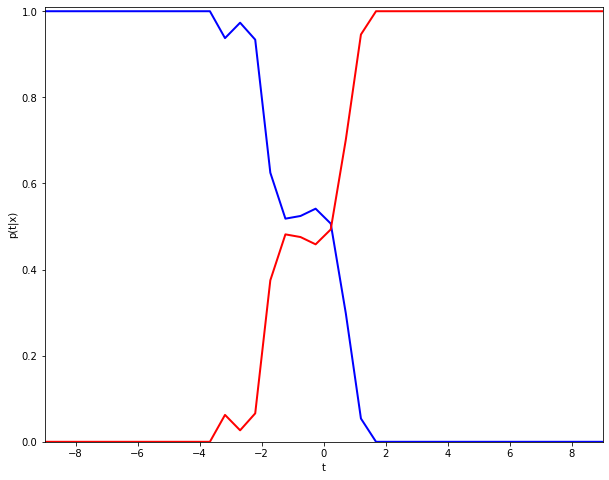

In [9]:
# Im Buch Abbildung 4-10
import math
from numpy.linalg import norm

tsize = 40 
t_sample = np.linspace(-10,9,tsize)
t_sample2 = t_sample + 1
def sign_(x,y,a,b): 
    if y > a*x+b:
        return 1
    else:
        return -1

def get_label_bin_p(d0,d1,a,b,x_class,y_class0,y_class1):
    pref1 = np.array([-10,a*(-10)+b])
    pref2 = np.array([10,a*10 + b])
    count_0 = 0
    count_1 = 0
    for ic,xc in enumerate(x_class):
        p3_0 = np.array([xc,y_class0[ic]])
        p3_1 = np.array([xc,y_class1[ic]])
        dc0 = norm(np.cross(pref2-pref1, pref1-p3_0))/norm(pref2-pref1)
        dc1 = norm(np.cross(pref2-pref1, pref1-p3_1))/norm(pref2-pref1)
        dc0_s = sign_(xc,y_class0[ic],a,b)
        dc1_s = sign_(xc,y_class1[ic],a,b)
        dc0 = dc0 * dc0_s
        dc1 = dc1 * dc1_s
        if dc0<d1 and dc0>d0:
            count_0 += 1
        if dc1<d1 and dc1>d0:
            #print(p3_1,dc1,dc1_s)
            count_1 += 1
    return count_0,count_1

p_0 = []
p_1 = []
for it,ts in enumerate(t_sample):
    c0, c1 = get_label_bin_p(ts,t_sample2[it],a,b,x_sample,y_class0,y_class1)
    p_0.append(c0)
    p_1.append(c1)
p_0 = np.array(p_0)
p_1 = np.array(p_1)
p_1[:14] = 0
print(p_0)
print(p_1)

fig = plt.figure(1, figsize=(10, 8))

plt.plot(t_sample, p_0/(p_0+p_1), c='b',lw=2.)
plt.plot(t_sample, p_1/(p_0+p_1), c='r',lw=2.)
plt.xlabel('t')
plt.ylabel('p(t|x)')
plt.xlim(-9,9)
plt.ylim(0,1.01)

In vielen Fällen können wir die Kurve in der vorherigen Abbildung mit der Kurve in der folgenden Abbildung modellieren.

Text(0, 0.5, 'p(t|x)')

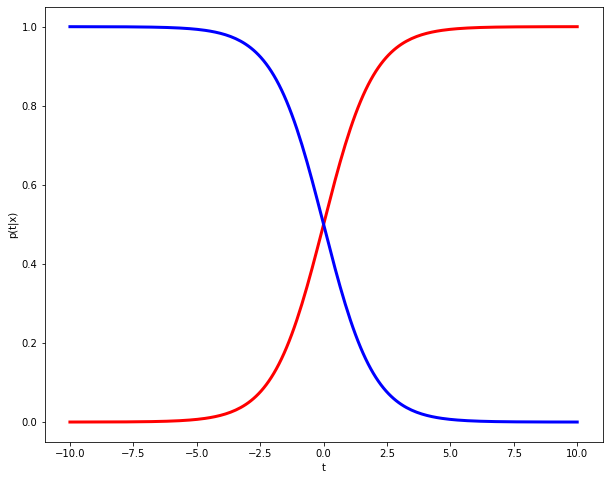

In [50]:
# Im Buch Abbildung 4-11
def logf(t):
    return 1./(1 + np.exp( -t ))


# In[33]:

fig = plt.figure(1, figsize=(10, 8))

t = np.linspace(-10,10,200) 
plt.plot(t, logf(t), lw=3., c='r')
plt.plot(t, 1-logf(t), lw=3., c='b')
plt.xlabel('t')
plt.ylabel('p(t|x)')

Dieses Modell macht die Annahme, dass man die Wahrscheinlichkeiten mit der logistischen Funktion beschreiben kann. Die Definition der logistischen Funktion $s$, wegen ihrer Form auch Sigmoid-Funktion genannt (siehe folgende Abbildung), lautet:

$$ s = \cfrac{1}{1+e^{(a\cdot x + b - y)}} $$

Text(0, 0.5, 'logistic function(t)')

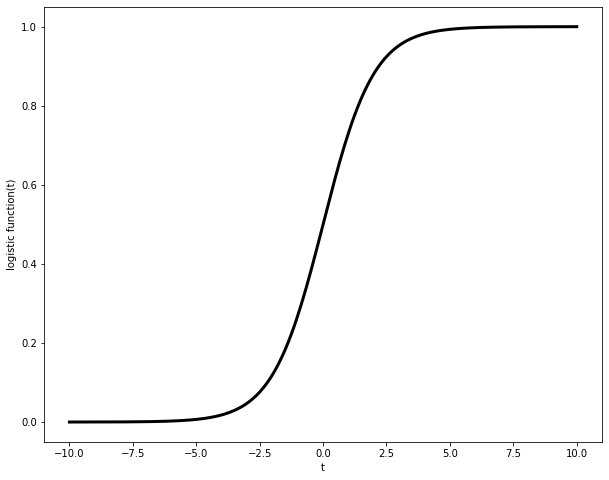

In [51]:
# IM Buch Abbildung 4-12
# Logisticshe Funktion (auch Sigmoid genannt)
fig = plt.figure(1, figsize=(10, 8))

t = np.linspace(-10,10,200) 
plt.plot(t, logf(t), lw=3.,c='k')
plt.xlabel('t')
plt.ylabel('logistic function(t)')

C:\Users\micha\AppData\Local\Temp/ipykernel_28564/3599220947.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


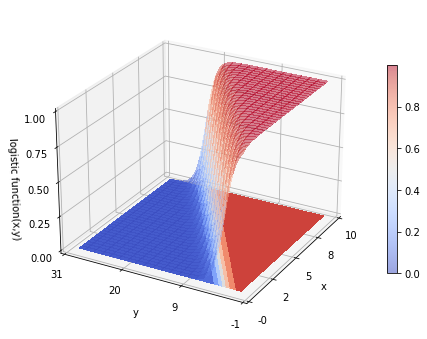

In [52]:
# Im Buch Abbildung 4-13
# Logistische Funktion zweidimensional
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
#import seaborn as sns

fig = plt.figure()
ax = fig.gca(projection='3d')

def logf_z(p,q,X,Y):
    return (1./(1. + np.exp( -(p*X + q)  + Y )))
    
X = np.arange(0, 10., 0.1)
Y = np.arange(0., 30., 0.1)
X, Y = np.meshgrid(X,Y)

#Z = 1-logf_z(2,3,X,Y)
Z = logf_z(2,3,X,Y)

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,  rstride=16, cstride=3, alpha=0.5,
                       linewidth=0, antialiased=False)


ax.set_zlim(0., 1.0)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('logistic function(x,y)')

ax.xaxis.set_major_locator(LinearLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.00f'))
ax.yaxis.set_major_locator(LinearLocator(4))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.00f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.64, aspect=20)

cset = ax.contourf(X, Y, Z, zdir='z', offset=0.001, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, Z, zdir='x', offset=-10, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, Z, zdir='y', offset=30, cmap=cm.coolwarm)

#nsample = 1000
#ax.scatter(x_class[0:nsample],y_class0[0:nsample], marker='.',alpha=0.9, c='b')
#ax.scatter(x_class[0:nsample],y_class1[0:nsample], marker='.',alpha=0.9, c='g')

ax.view_init(25, -151)

plt.gcf().subplots_adjust(left=-0.25)
plt.gcf().subplots_adjust(bottom=-0.25)
#plt.xlabel('x')
#plt.ylabel('y')

In [53]:
# Im Folgenden zeigen wir noch, wie man mit sklearn den Demodatensatz klassifizieren kann, aber das ist besser für später
import sklearn.linear_model as lm

logr = lm.LogisticRegression()

In [54]:
# unfortunately a bit complex to constrcut X
x1 = np.append(x_class[y_class0>=0], x_class[y_class1>=0])
x2 = np.append(y_class0[y_class0>=0], y_class1[y_class1>=0])
X = np.array([x1, x2]).T

# 0 is for class0, 1 for class1
y = np.append(np.zeros(len(y_class0[y_class0>=0])), np.ones(len(y_class1[y_class1>=0])))

In [55]:
logr.fit(X, y)

LogisticRegression()

In [56]:
logr.score(X, y)

0.8306922435362802

## Logistische Regression der Irisdaten

In Sklearn kannst du den Klassifkator LogisticRegression() aus der Bibliothek linear_model aufrufen:
```Python
import sklearn.linear_model as lm
logr = lm.LogisticRegression()
```

Sklearn erkennt an den Shapes der Inputs $X$ und $y$ automatisch, wie viele Features für den Datensatz berücksichtigt werden sollen. Im
obigen Beispiel hatten wir die zwei Features $X$ und $y$. Der Irisdatensatz enthält drei Klassen und vier Features. Wir können nun mit
nur wenigen Zeilen die etwas komplexeren Irisdaten mit logistischer Regression auswerten:

In [2]:
# Lade die Irisdaten und erstelle X, y
import numpy as np
from sklearn.datasets import load_iris
iris = load_iris()

X = np.array(iris.data)
y = np.array(iris.target)
X.shape, y.shape

((150, 4), (150,))

In [58]:
# Trainiere einen Klassifikator LogisticRegression
# zu finden in sklearn.linear_model
import sklearn.linear_model as lm 
logr = lm.LogisticRegression()
logr.fit(X,y)
logr.score(X,y)

c:\tools\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9733333333333334

Dabei werden im vierdimensionalen Feature-Raum die linearen Hyperflächen ermittelt. Eine Linie kann man mit einem Punkt in
zwei Bereiche aufteilen, bei einem zweidimensionalen Raum geht das mit einer Linie. Bei höheren Dimensionen spricht man von
Hyperebenen oder -flächen, die den n-dimensionalen Feature-Raum aufteilen. Die Hyperfläche hat also immer eine Dimension weniger
als der Feature-Raum. In diesem vierdimensionalen Beispiel ist die Hyperdimension also drei.

Auf diese Weise berücksichtigt man die Korrelationen zwischen allen vier Features. Wenn man sich z.B. nur paarweise zwei Features anguckt und dort jeweils die beste Gerade bestimmt (siehe folgende Abbildung), würde man jeweils nur die paarweisen Korrelationen berücksichtigen und nicht alle vier gleichzeitig. Wichtige Informationen hätte man nicht genutzt.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


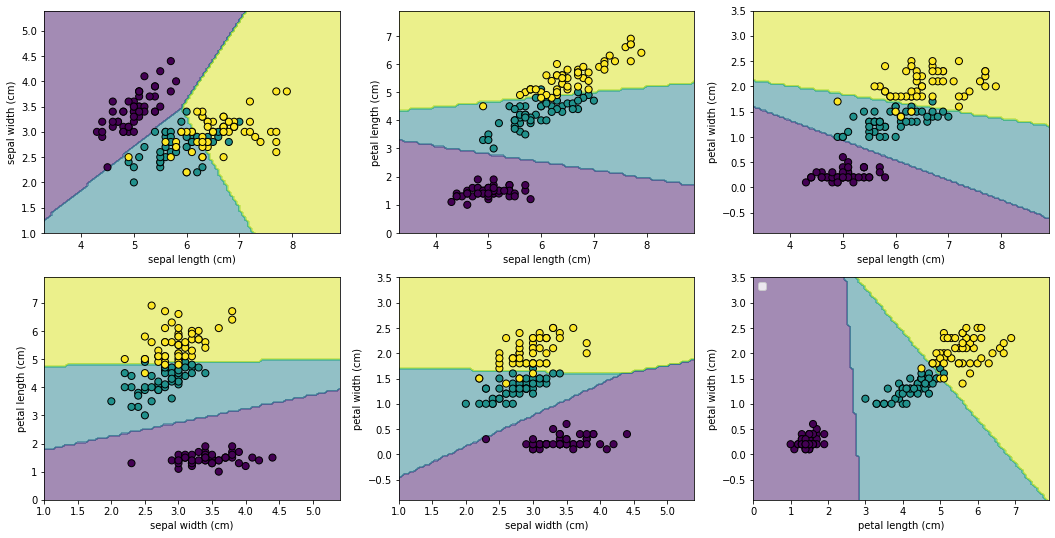

In [10]:
# Im Buch Abbildung 4-14
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
import sklearn.linear_model as lm 

n_classes = 3
colors = 'bwr' #['b','y','r']
CMAP = colors #plt.cm.rainbow
plot_step = 0.01

fig = plt.figure(1, figsize=(18, 9))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    logr = lm.LogisticRegression()
    clf = logr.fit(X, y)

    plt.subplot(2, 3, pairidx + 1)

    disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, ax=plt.gca())
    disp.ax_.scatter(X[:,0], X[:, 1], s=50, c=y, edgecolors="k")

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    plt.axis("tight")

plt.legend(loc='upper left')

In [66]:
# Im folgenden Code geben wir die Scores für jede mögliche Gerade aus:
for pair in [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]:
    X = iris.data[:, pair]
    y = iris.target

    logrfit = logr.fit(X, y)
    print(logr.score(X, y))

0.82
0.96
0.96
0.9533333333333334
0.96
0.9666666666666667


Wie du anhand dieser Ausgaben sehen kannst, sind alle Scores geringer als der Score, den wir mit allen vier Features erreicht haben.

## Support Vector Machine

Visueller Experimentierkasten:
https://dash.gallery/dash-svm/

In Sklearn wird diese Klassifikationsmethode auch Support Vector Classifier genannt (SVC). Ihr Vorteil gegenüber der logistischen Regression ist, dass sie bei kleineren Datensätzen oft bessere Ergebnisse liefert. Dies hängt mit dem Problem der hohen Dimensionen zusammen, das wir in Kapitel 5, Feature-Auswahl, diskutieren.

Wir wollen zunächst ein einfaches Klassifikationsproblem betrachten, bei dem die beiden Klassen in der Feature-Ebene (x-y) linear separierbar sind, was bedeutet, dass es keine Überlappungen zwischen zwei Klassen gibt. Dies kannst du gut in Abbildung 4-15 erkennen.

Text(0, 0.5, 'y')

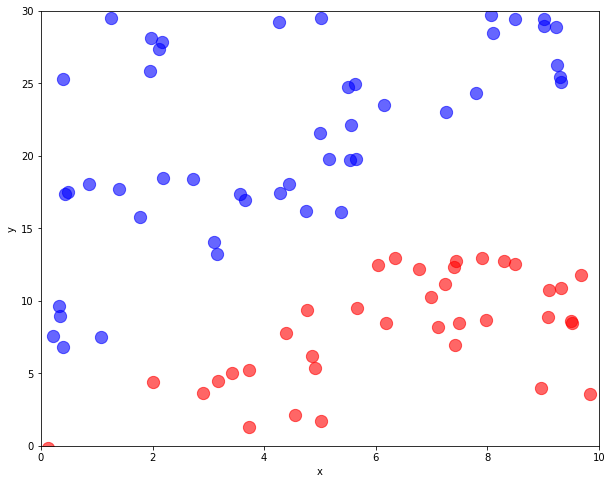

In [22]:
# Im Buch Abbildung 4-15
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
np.random.seed(7529)

fig = plt.figure(1, figsize=(10, 8))

def line(a,b,x):
    return a*x+b

x = np.linspace(0,10)
a = 2
b = 3

xlim = [0,10]
ylim = [0,30]

# Erzeuge 75 Punkte oberhalb und unterhalb der Geraden mit Abstand größer bzw. kleiner 2
size = 75
X_0 = np.array([ (x, line(a, b, x) + 2 + np.random.uniform(size=1) * 25.) for x in np.random.uniform(size=size) * 10 ], dtype="object").reshape(-1, 2)
X_1 = np.array([ (x, line(a, b,  x) - 2 - np.random.uniform(size=1) * 25) for x in np.random.uniform(size=size) * 10 ], dtype="object").reshape(-1, 2)
X = np.append(X_0, X_1).reshape(-1, 2)
y = np.array([ 0 if y >  line(a, b, x) else 1 for x,y in X])


plt.scatter(X[y==1][:,0], X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0], X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
plt.xlabel('x')
plt.ylabel('y')

Bei der logistischen Regression haben wir nach einer Geraden gesucht, die die beiden Klassen in der $x$-$y$-Ebene am besten trennt. Die logistische Loss-Funktion diente dabei als Kriterium. Die Minimierung der logistischen Loss-Funktion kann man interpretieren als Minimierung der Klassifizierungsunsicherheit oder als Minimierung der Missklassifizierungswahrscheinlichkeit.

Die lineare Support-Vector-Machine-Methode sucht nach der Geraden (der durchgezogenen Linie in Abbildung 4-16), die den größtmöglichen Abstand zu den jeweils nächstgelegenen Punkten (Support Vectors) der verschiedenen Klassen besitzt. Wie schon im vorigen Abschnitt erwähnt, nennt man diese Trennungsgerade in höheren Dimensionen auch Hyperfläche. Die Region zwischen den beiden gestrichelten Linien kann als Trennungsband (Margin) interpretiert werden. Im Fall von separierbaren Problemen, wie in unserem Beispiel hier, kann man eine Region finden, die die beiden Klassen perfekt trennt (Hard-Margin):

In [24]:
# Model
# Trainiere eine SVM (hier SVC für Klassifikation) von sklearn.svm und markiere Support-Vektoren
from sklearn.svm import SVC
model1 = SVC(kernel='linear', C=1) # Hard-Margin!
model1.fit(X, y)
model1.score(X, y)

1.0

C:\Users\micha\AppData\Local\Temp/ipykernel_6460/3284999939.py:20: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,


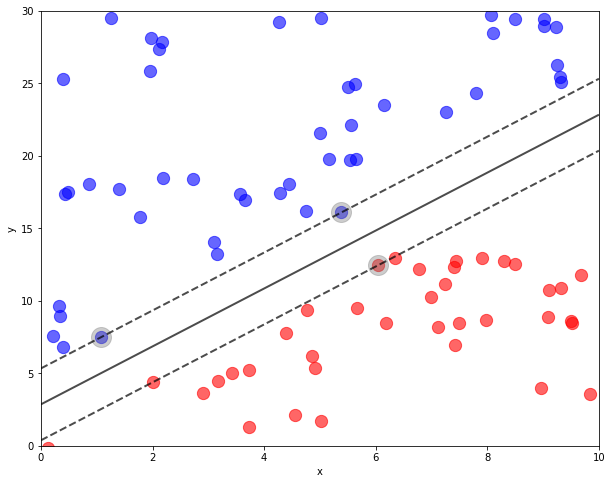

In [25]:
# Im Buch Abbildung 4-16

NBINS = 25
xg = np.linspace(xlim[0], xlim[1], NBINS)
yg = np.linspace(ylim[0], ylim[1], NBINS)
Yg, Xg = np.meshgrid(yg, xg)
xy = np.vstack([Xg.ravel(), Yg.ravel()]).T
P1 = model1.decision_function(xy).reshape(Xg.shape)

plt.figure(figsize=(10, 8))

plt.scatter(X[y==1][:,0], X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0], X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')
plt.xlim(xlim[0], xlim[1])
plt.ylim(ylim[0], ylim[1])
plt.xlabel('x')
plt.ylabel('y')

# decision boundary and margins:
cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,
                levels=[-1, 0, 1], alpha=0.7,
                linestyles=['--', '-', '--'])
plt.setp(cont.collections,lw=2)
# support vectors:
plt.scatter(model1.support_vectors_[:, 0], model1.support_vectors_[:, 1], s=400, linewidth=1, facecolors='grey', alpha=0.39);

Diese Hyperfläche, in unserem Fall also die Trennungsgerade, findetman, indem man die sogenannte Hinge-Loss-Funktion minimiert:
$$ L = \sum \max \left(0, 1 - t(wx + b)\right) $$

Dabei bezeichnet $t$ das Label (–1, 1: blau, rot), und $w·x + b$ bezeichnet die Geradenfunktion in Vektorschreibweise. Wenn $w$ also der Normalenvektor der Geraden ist und $x$ der Vektor eines Punkts, kann man $w·x$, also das skalare Vektorprodukt, auch als ein Maß
für den Abstand des Punkts $x$ zu der Geraden interpretieren. Wir wollen $w·x + b$ maximieren, also $1 –(w·x + b)$ minimieren.

![](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fsvm.michalhaltuf.cz%2Fwp-content%2Fuploads%2F2017%2F10%2Fmargin.png&f=1&nofb=1)

Für die Berechnung der Lösung ist es wichtig, dass nur wenige Punkte diese Hyperfläche bestimmen. Im separierbaren Fall sind es
lediglich die Punkte, die auf den Grenzen der Margin liegen. Diese heißen **Support Vectors** (eingegraute Punkte in Abbildung 4-16) und
geben dieser Methode auch ihren Namen. Die Punkte, die auf der falschen Seite der Linie liegen, wollen wir mit einem negativen Faktor belegen, also $1 – t·(w·x + b)$.

Für die Betrachtung von nicht linear separierbaren Klassen haben wir, wie in Abbildung 4-17 zu sehen, zwei Klassen mit Überlappungen generiert.

C:\Users\micha\AppData\Local\Temp/ipykernel_35288/3343642532.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_0 = np.array([ (x,line(a,b,x) + np.random.uniform(size=1)*25.) for x in np.random.uniform(size=size)*10  ]).reshape(-1,2)
C:\Users\micha\AppData\Local\Temp/ipykernel_35288/3343642532.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_1 = np.array([ (x,line(a,b,x) - np.random.uniform(size=1)*25) for x in np.random.uniform(size=size)*10  ]).reshape(-1,2)


(0.0, 30.0)

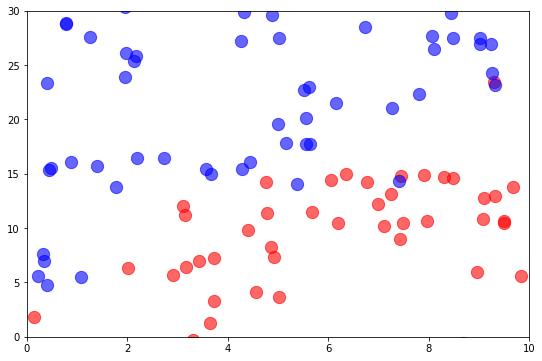

In [14]:
# Im Buch Abbildung 4-17
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
np.random.seed(7529)

fig = plt.figure(1, figsize=(9, 6))

def line(a,b,x):
    return a*x+b

x = np.linspace(0,10)
a = 2
b = 3

xlim = [0,10]
ylim = [0,30]

size = 75
X_0 = np.array([ (x,line(a,b,x) + np.random.uniform(size=1)*25.) for x in np.random.uniform(size=size)*10  ]).reshape(-1,2)
X_1 = np.array([ (x,line(a,b,x) - np.random.uniform(size=1)*25) for x in np.random.uniform(size=size)*10  ]).reshape(-1,2)
X = np.append(X_0,X_1).reshape(-1,2)
y = np.array([ 0 if y > (line(a,b,x) - (np.random.uniform(size=1)*10. - 5) ) else 1 for x,y in X])


plt.scatter(X[y==1][:,0],X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0],X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')
plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])


Bei linear nicht separablen Klassen ist es sinnvoll, der Loss-Funktion einen weiteren Term hinzuzufügen, der die Toleranz von
Punkten auf der falschen Seite kontrolliert:

$$ L = \sum \max \left(0, 1 - t(wx + b)\right) + \lambda \cdot w^2 $$

Je größer $\lambda$ gewählt wird, desto stärker erhöht man die Toleranz dieser missklassifizierten Punkte an der Grenzlinie.

Sklearn benutzt die externe Bibliothek libsvm (https://www.csie.ntu.edu.tw/~cjlin/libsvm/), die den Parameter $C$ zur Regulierung verwendet. $C$ ist umgekehrt proportional zu $\lambda$: $C \propto 1/\lambda$. Je kleiner $C$ gewählt wird, desto stärker erhöht man die Toleranz dieser missklassifizierten Punkte an der Grenzlinie. Man weicht die Region regelrecht auf, deshalb heißt sie auch Soft-Margin (siehe Abbildung 4-18).

C:\Users\micha\AppData\Local\Temp/ipykernel_35288/1013189908.py:19: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,


Text(0, 0.5, 'y')

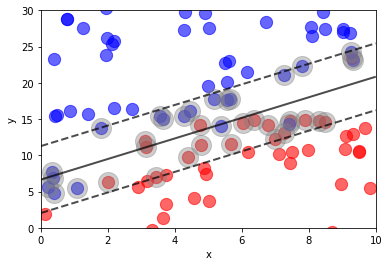

In [21]:
# Model
from sklearn.svm import SVC
model1 = SVC(kernel='linear', C=1.E-2)
model1.fit(X, y)

NBINS = 25
xg = np.linspace(xlim[0], xlim[1], NBINS)
yg = np.linspace(ylim[0], ylim[1], NBINS)
Yg, Xg = np.meshgrid(yg, xg)
xy = np.vstack([Xg.ravel(), Yg.ravel()]).T
P1 = model1.decision_function(xy).reshape(Xg.shape)

plt.scatter(X[y==1][:,0],X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0],X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')
plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])

# decision boundary and margins:
cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,
                levels=[-1, 0, 1], alpha=0.7,
                linestyles=['--', '-', '--'])
plt.setp(cont.collections,lw=2)
# support vectors:
plt.scatter(model1.support_vectors_[:, 0],model1.support_vectors_[:, 1],s=400, linewidth=1, facecolors='grey',alpha=0.39);

plt.xlabel('x')
plt.ylabel('y')

Für einen $C$-Wert von 100 erhalten wir beispielsweise einen Score von über 0,95:

In [29]:
model2 = SVC(kernel="linear", C=100)
model2.fit(X, y)
model2.score(X, y)

0.9533333333333334

Wenn wir C von 100 auf 0.01 ändern, weichen wir die Margin auf (siehe Abbildung 4-18):

In [30]:
model3 = SVC(kernel='linear', C=1.E-2)
model3.fit(X, y)
model3.score(X, y)

0.9333333333333333

Der optimale Wert für $C$ hängt vom Problem und den jeweiligen Daten ab. Meist findet man ihn nur durch Ausprobieren. Die Anpassung der Parameter zur Vermeidung von Overfitting vor und während der Trainingsphase nennt man Regularisierung. Methoden zur Optimierung und Regularisierung von Parametern besprechen ausführlicher in Kapitel 5, Feature-Auswahl.

## Nichtlineare SVM

Um nicht-lineare Verteilungen zu trennen, bedient man sich eines Tricks. Dabei werden die ursprünglichen Koordinaten, die durch unsere Input-Variablen vorgegeben sind, in einem neuen FeatureKoordinatensystem so transformiert, dass die Klassen wieder durch eine Gerade trennbar sind. Grundsätzlich können fast alle Funktionen durch eine Summe von verschiedenen Basisfunktionen approximiert werden, z.B. durch Polynome oder Gaußfunktionen. Letztere ist ein Spezialfall einer sogenannten Radial-Basis-Funktion (RBF), die sehr häufig benutzt wird.

SVM bedienen sich eines weiteren Tricks: Statt die Koordinatentransformationen für alle Trainingsbeispiele durchzuführen und dann die Distanzberechnung in dem Feature-Raum vorzunehmen, werden Kernelfunktionen eingesetzt. Mit Kernelfunktionen kann man die Distanz in dem Feature-Raum berechnen, ohne die Koordinatentransformation explizit auszuführen. Das ist der sogenannte Kerneltrick, der bei hohen Dimensionen viel Rechenaufwand sparen kann.

Diese Vorgehensweise ist äquivalent zu einem Mapping der InputVariablen vom Input-Raum in den Feature-Raum, bei der die Hyperfläche linear ist (Abbildung 4-19).

![](images/4_19.png)


In [31]:
import numpy as np
import matplotlib.pylab as plt
np.random.seed(7429)

Ein Beispiel für die Anwendung von RBF-Kerneln in SVM ist in Abbildung 4-20 dargestellt. Eine perfekte Trennung erhält man durch die Anwendung einer SVM mit Radial-Basis-Funktionen (RBF) als Kernel:

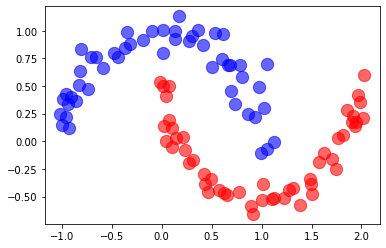

In [33]:
x = np.linspace(0,10)
xlim = [0,10]; ylim = [0,30]

from sklearn.datasets import make_moons
X, y = make_moons(100, noise=0.08, shuffle=True)

plt.scatter(X[y==1][:,0],X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0],X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')

In [36]:
model4 = SVC(kernel='rbf', C=1E6, gamma=1.) # hier Wahl des Kernel beachten
model4.fit(X, y)
print(model4.score(X,y))

1.0


C:\Users\micha\AppData\Local\Temp/ipykernel_6460/1536615826.py:23: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,


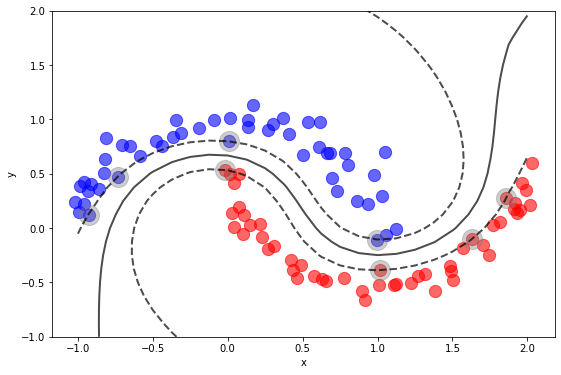

In [35]:
# Im Buch Abbildung 4-20
fig = plt.figure(1, figsize=(9, 6))

plt.scatter(X[y==1][:,0], X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0], X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')

plt.xlabel('x')
plt.ylabel('y')

# model
from sklearn.svm import SVC
model1 = SVC(kernel='rbf', C=1E6, gamma=1.)
model1.fit(X, y)

NBINS = 25
xg = np.linspace(-1, 2, NBINS)
yg = np.linspace(-1, 2, NBINS)
Yg, Xg = np.meshgrid(yg, xg)
xy = np.vstack([Xg.ravel(), Yg.ravel()]).T
P1 = model1.decision_function(xy).reshape(Xg.shape)

# decision boundary and margins
cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,
                levels=[-1,0,1], alpha=0.7,
                linestyles=['--','-','--'])
plt.setp(cont.collections,lw=2)
# support vectors
plt.scatter(model1.support_vectors_[:, 0],model1.support_vectors_[:, 1],s=400, linewidth=1,  facecolors='grey',alpha=0.39);

### Overfitting

Zur Gruppe der Radial-Basis-Funktionen gehören alle Funktionen, deren Wert nur abhängig von der Distanz zu einem bestimmten Mittelpunkt ist. Gaußfunktionen gehören damit z.B. auch zu den RBF. Der Parameter Gamma für die RBF bestimmt dabei, wie schnell oder wie langsam der Wert der Funktion in Abhängigkeit zur Distanz vom Mittelpunkt fällt. Je größer der Gammawert, desto schneller wird der Funktionswert kleiner.

Somit sind RBF sehr gut geeignet, um beliebige Kurven anzupassen oder zu glätten. Jede Kurve kann durch eine Summe von RBF angenähert werden. Den Einfluss jeder einzelnen Funktion kann man über den jeweiligen Gammawert kontrollieren. Die einzelne Funktion hat jeweils einen großen oder geringen lokalen Einfluss auf die Gesamtfunktion. Man kontrolliert somit die Granularität der Approximation.

Genau so kann man auch die Granularität des SVM-Klassifikators kontrollieren. Im obigen Beispiel wurde ein Gammawert von $1$ benutzt. Die Bedeutung der Granularität im Fall von Klassifikatoren können wir illustrieren, indem wir Gamma auf $100$ erhöhen. Wir sehen, dass der Classifier überfittet, weil er jedem einzelnen Trainingsbeispiel zu viel Wert einräumt, das Modell ist zu komplex (siehe Abbildung 4-21).

Verringern wir hingegen den Gammawert auf $0,001$, sehen wir Underfitting. Die Granulation ist zu gering, um die Struktur abzubilden, das Model ist zu einfach (siehe auch Abbildung 4-22)

C:\Users\micha\AppData\Local\Temp/ipykernel_6460/1846478651.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,


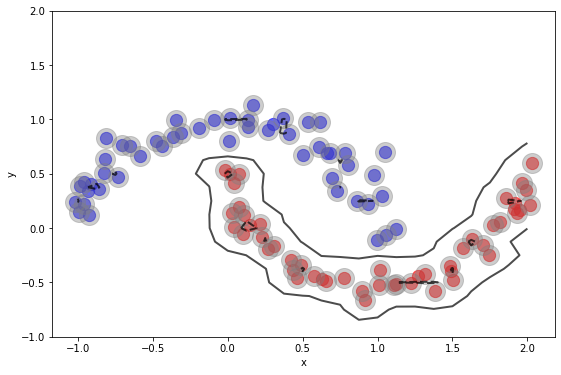

In [40]:
fig = plt.figure(1, figsize=(9, 6))

plt.scatter(X[y==1][:,0],X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0],X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')

plt.xlabel('x')
plt.ylabel('y')

# model
model1 = SVC(kernel='rbf', C=1E6, gamma=1E2)
model1.fit(X, y)

NBINS = 25
xg = np.linspace(-1, 2, NBINS)
yg = np.linspace(-1, 2, NBINS)
Yg, Xg = np.meshgrid(yg, xg)
xy = np.vstack([Xg.ravel(), Yg.ravel()]).T
P1 = model1.decision_function(xy).reshape(Xg.shape)

# decision boundary and margins
cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,
                levels=[-1,0,1], alpha=0.7,
                linestyles=['--','-','--'])
plt.setp(cont.collections,lw=2)
# support vectors
plt.scatter(model1.support_vectors_[:, 0],model1.support_vectors_[:, 1],s=400, linewidth=1, facecolors='grey',alpha=0.39);

### Underfitting

C:\Users\micha\AppData\Local\Temp/ipykernel_6460/3951884694.py:19: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,


Text(0, 0.5, 'y')

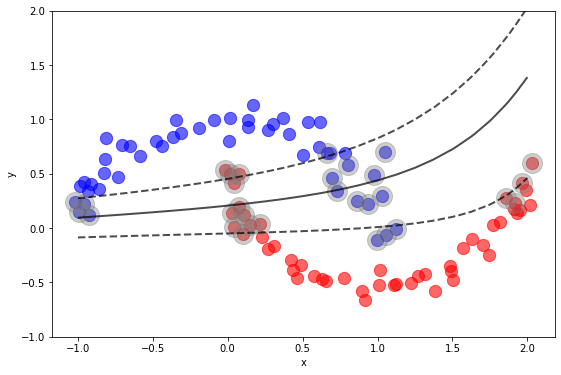

In [41]:
fig = plt.figure(1, figsize=(9, 6))

plt.scatter(X[y==1][:,0],X[y==1][:,1], s=150, marker='o',alpha=0.6, c='r')
plt.scatter(X[y==0][:,0],X[y==0][:,1], s=150, marker='o',alpha=0.6, c='b')

# model
from sklearn.svm import SVC
model1 = SVC(kernel='rbf', C=1E6, gamma=1E-3)
model1.fit(X, y)

NBINS = 25
xg = np.linspace(-1, 2, NBINS)
yg = np.linspace(-1, 2, NBINS)
Yg, Xg = np.meshgrid(yg, xg)
xy = np.vstack([Xg.ravel(), Yg.ravel()]).T
P1 = model1.decision_function(xy).reshape(Xg.shape)

# plot decision boundary and margins
cont = plt.contour(Xg, Yg, P1, colors='k',linewidth=9,
                levels=[-1,0,1], alpha=0.7,
                linestyles=['--','-','--'])
plt.setp(cont.collections,lw=2)
# support vectors
plt.scatter(model1.support_vectors_[:, 0],model1.support_vectors_[:, 1],s=400, linewidth=1, facecolors='grey',alpha=0.39);

plt.xlabel('x')
plt.ylabel('y')

## SVM mit IRIS

In [43]:
# Lade die Irisdaten und erstelle X, y
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

In [47]:

# Trainiere eine lineare SVM mit Parameter C=1
model6 = SVC(kernel='linear', C=1)
model6.fit(X, y)
print(model6.score(X,y))

0.9933333333333333


In [48]:
# Trainiere eine nicht-lineare SVM mit sinnvollen Parametern
model7 = SVC(kernel='rbf', C=1, gamma=1)
model7.fit(X, y)
print(model7.score(X,y))

0.98


In [49]:
model8 = SVC(kernel='rbf', C=1000, gamma=1)
model8.fit(X, y)
print(model8.score(X,y))

1.0


In [50]:
from sklearn.datasets import load_iris
iris = load_iris()

X = iris.data
y = iris.target

Die nicht-linearen dreidimensionalen Hyperflächen, die von der SVM ermittelt werden, lassen sich sehr schwer im vierdimensionalen Feature-Raum darstellen. Deshalb verzichten wir hier wieder darauf. Einen gewissen – aber dennoch eingeschränkten – Eindruck erhältst du, wenn wir wieder paarweise die zweidimensionalen Entscheidungsflächen darstellen (siehe Abbildung 4-23).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


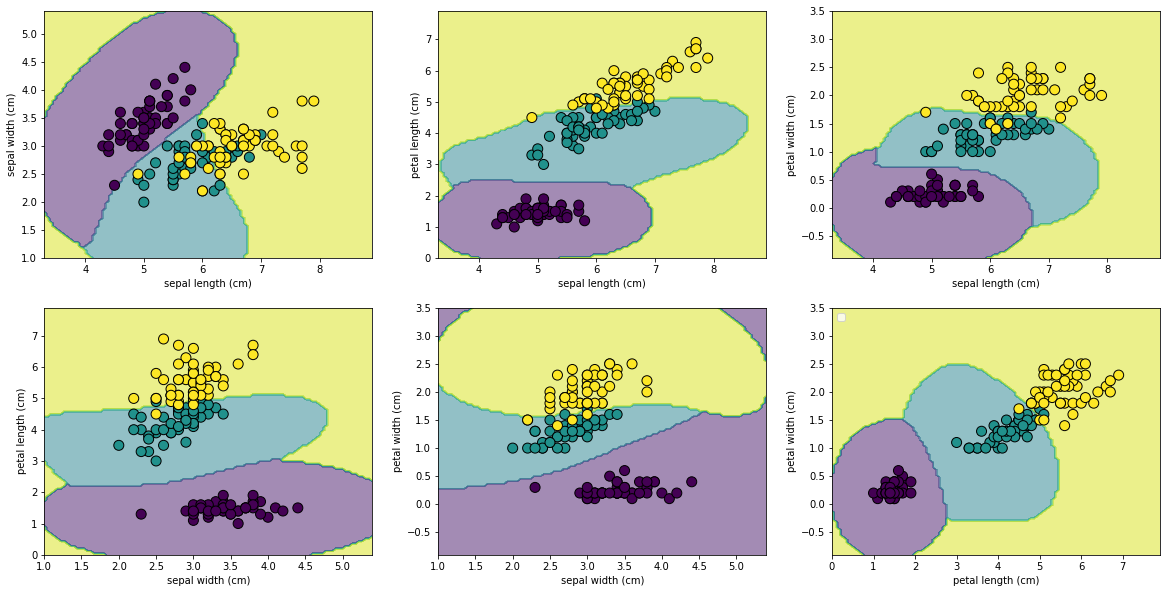

In [27]:
# Im Buch Abbildung 4-23
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.svm import SVC
svc = SVC(kernel='rbf', C=1E0, gamma=1.)

n_classes = 3
colors = 'bwr'#['b','y','r']
CMAP = colors#plt.cm.rainbow
plot_step = 0.01

fig = plt.figure(1, figsize=(20, 10))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    clf = svc.fit(X, y)

    plt.subplot(2, 3, pairidx + 1)

    disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, ax=plt.gca())
    disp.ax_.scatter(X[:, 0], X[:, 1], s=100, c=y, edgecolor="k")

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    plt.axis("tight")

plt.legend(loc='upper left')

## Decision Tree Klassifikator

Decision Trees haben einige Vorteile gegenüber den beiden schon beschriebenen Klassifikationsmethoden. Man benötigt in der Regel
keine so aufwendige Vorverarbeitung (Preprocessing), weil kategorische Input-Variablen nicht als Zahlen codiert werden müssen. Du
kannst sogar numerische und kategorische Features simultan benutzen. Zudem kann eine Rangfolge der relevantesten Features
nach der Trainingsphase relativ leicht extrahiert werden. Dies ist vor allem wichtig, wenn du die Entscheidungskriterien des Modells
nachvollziehen möchtest. Decision Trees tendieren aber auch zu Overfitting. Es gibt einige Techniken zur Regularisierung, aber
diese sind in der Praxis oft recht aufwendig. Häufig sind Ergebnisse nicht reproduzierbar, weil kleine Änderungen in den Daten manchmal schon zu gänzlich unterschiedlichen Baumstrukturen führen können.

Als einfaches Beispiel erzeugen und betrachten wir wieder zwei verschiedene Klassen (rot und blau dargestellt in Abbildung 4-24) mit
den Features $x$ und $y$

Text(0, 0.5, 'y')

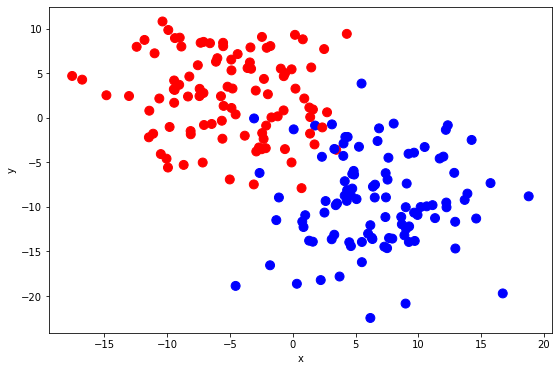

In [75]:
# Im Buch Abbildung 4-24
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pylab as plt

RNDST = np.random.seed(52)
CMAP = 'bwr'
fig = plt.figure(1, figsize=(9, 6))

X, y = make_blobs(n_samples=200, centers=2, random_state=RNDST, cluster_std=5.)
plt.scatter(X[:, 0], X[:, 1], s=80, c=y, cmap=CMAP)

plt.xlabel('x')
plt.ylabel('y')

Wenn wir den DecisionTreeClassifier von Sklearn auf dieses Problem anwenden, können wir die Entscheidung des Klassifikators
wieder mithilfe farbiger Entscheidungsflächen visualisieren (siehe Abbildung 4-25)

In [76]:
# Trainiere einen Entscheidungsbaum als Klassifikatormodell
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X, y)
print(tree.score(X,y))

1.0


Text(0, 0.5, 'y')

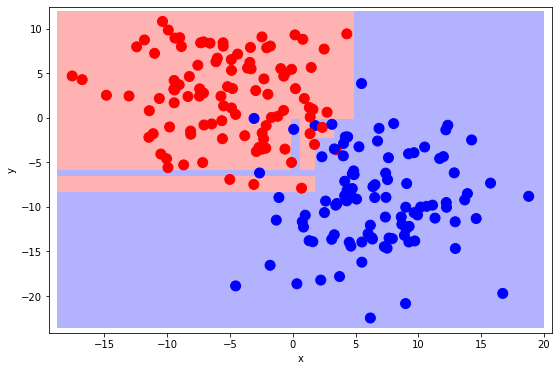

In [86]:
# Visualisiere die Entscheidungsgrenzen
# Im Buch Abbildung 4-25
from sklearn.inspection import DecisionBoundaryDisplay
fig = plt.figure(1, figsize=(9, 6))
ax = plt.gca()
    
ax.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap=CMAP, clim=(y.min(), y.max()), zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh")

plt.xlabel('x')
plt.ylabel('y')

Eine schematische Darstellung des Entscheidungsbaums könnte in etwa aussehen wie in Abbildung 4-26 (in der Abbildung wurden aus
Platzgründen die Verzweigungswerte auf ganze Zahlen gerundet)

![](images/4_26.png)

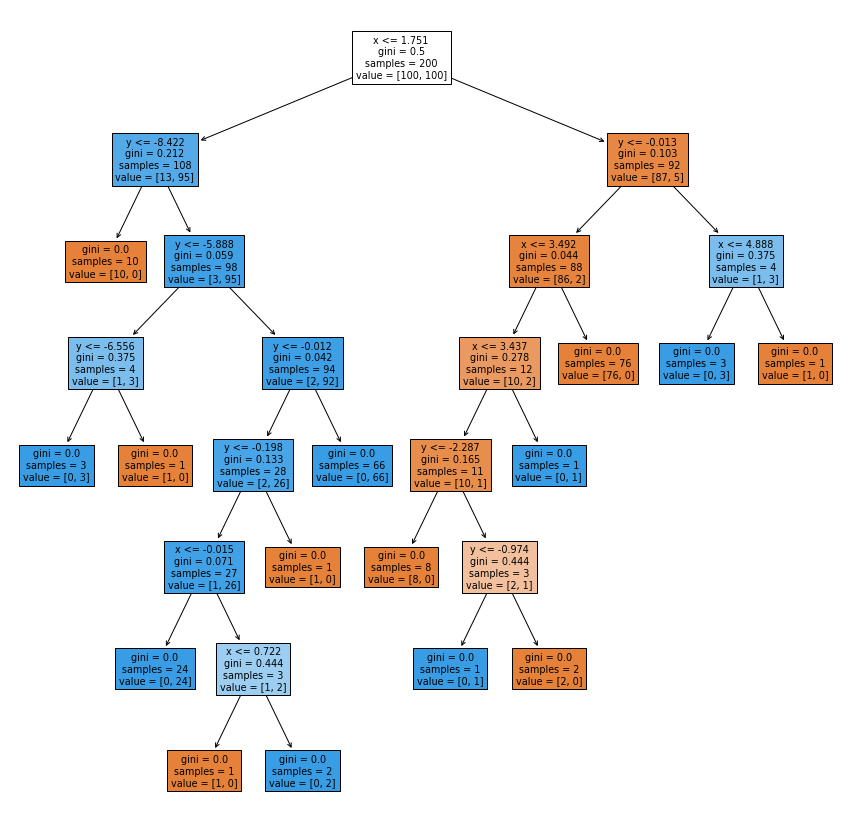

In [90]:
# Visualisiere den Entscheidungsbaum mit sklearn plot_tree
from sklearn.tree import plot_tree

plt.figure(figsize=(15,15))
plot_tree(tree, filled=True, feature_names=["x", "y"])
None

### Level 1

Auf der ersten Ebene teilt der Algorithmus alle Trainingsbeispiele in zwei Zweige: in die Beispiele mit dem $x$-Wert kleiner als 1,75 (erster
Zweig) bzw. größer als 1,75 (zweiter Zweig, siehe Abbildung 4-27). Selbst mit dieser sehr groben Einteilung kommen wir bereits auf
einen erstaunlich guten Score. Wir setzen dazu max_depth auf 1, um nur die erste Ebene zu nutzen:

In [37]:
# Trainiere einen Entscheidungsbaum mit der Tiefe 1
tree1 = DecisionTreeClassifier(max_depth=1)
tree1.fit(X, y)
print(tree1.score(X,y))

0.91


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

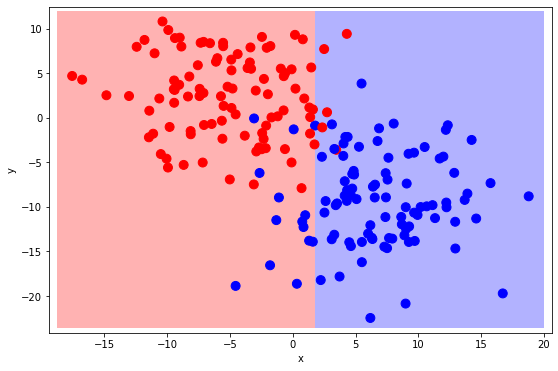

In [90]:
# Visualisiere die Entscheidungsgrenze
# Abbildung 4-27
tree1 = DecisionTreeClassifier(max_depth=1)
tree1.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree1, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh")

plt.xlabel('x')
plt.ylabel('y')

[Text(0.5, 0.75, 'x <= 1.751\ngini = 0.5\nsamples = 200\nvalue = [100, 100]'),
 Text(0.25, 0.25, 'gini = 0.212\nsamples = 108\nvalue = [13, 95]'),
 Text(0.75, 0.25, 'gini = 0.103\nsamples = 92\nvalue = [87, 5]')]

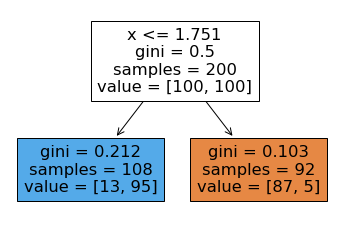

In [91]:
# Visualisiere den Baum
from sklearn.tree import plot_tree

plot_tree(tree1, filled=True, feature_names=["x", "y"])

### Level 2

Auf der zweiten Ebene werden die jeweiligen Zweige wiederum in je zwei weitere Zweige geteilt. Der erste Zweig ($x <= 1,75$) wird geteilt in die Beispiele mit $y < –8,4$ und $y > –8,4$, während der zweite Zweig ($x > 1,75$) bei etwa $y = 0$ geteilt wird (siehe Abbildung
4-28):

In [50]:
# Trainiere einen Entscheidungsbaum mit Tiefe 2
tree2 = DecisionTreeClassifier(max_depth=2)
tree2.fit(X, y)
print(tree2.score(X,y))

0.97


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

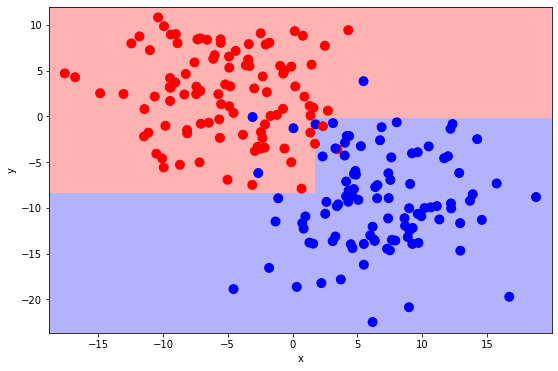

In [91]:
# Visualisiere die Entscheidungsgrenze
# Abbildung 4-28
tree2 = DecisionTreeClassifier(max_depth=2)
tree2.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, zorder=3)

disp = DecisionBoundaryDisplay.from_estimator(tree2, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict") # try predict_prob!

plt.xlabel('x')
plt.ylabel('y')

[Text(0.5, 0.8333333333333334, 'x <= 1.751\ngini = 0.5\nsamples = 200\nvalue = [100, 100]'),
 Text(0.25, 0.5, 'y <= -8.422\ngini = 0.212\nsamples = 108\nvalue = [13, 95]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.059\nsamples = 98\nvalue = [3, 95]'),
 Text(0.75, 0.5, 'y <= -0.013\ngini = 0.103\nsamples = 92\nvalue = [87, 5]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.044\nsamples = 88\nvalue = [86, 2]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]')]

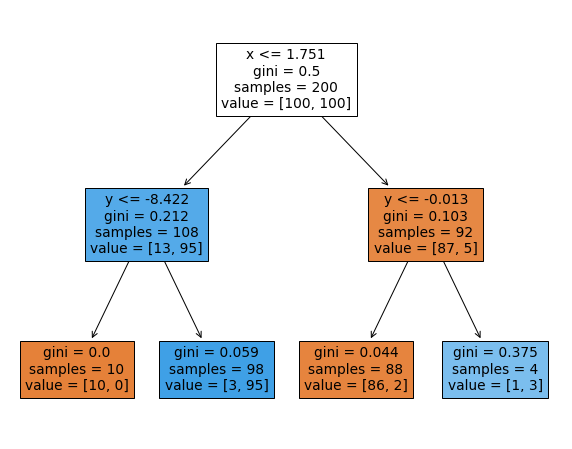

In [92]:
# Visualisiere den Baum
from sklearn.tree import plot_tree

plt.figure(figsize=(10,8))
plot_tree(tree2, filled=True, feature_names=["x", "y"])

### Level 3

In [41]:
tree3 = DecisionTreeClassifier(max_depth=3)
tree3.fit(X, y)
print(tree3.score(X,y))

0.975


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

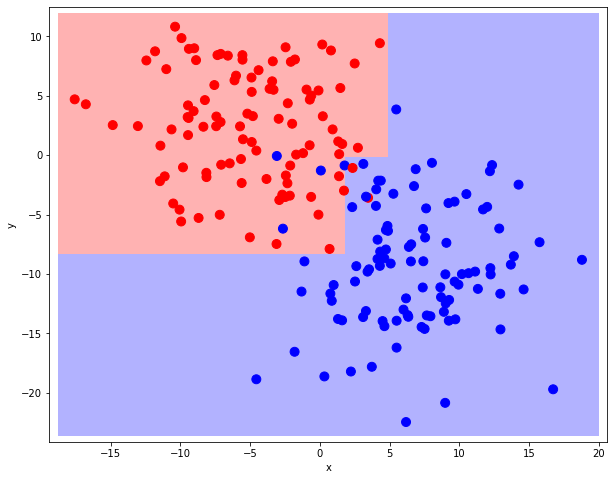

In [92]:
# Abbildung 4-29
tree3 = DecisionTreeClassifier(max_depth=3)
tree3.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree3, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict") # try predict_prob!

plt.xlabel('x')
plt.ylabel('y')

### Level 4

In [65]:
tree4 = DecisionTreeClassifier(max_depth=4)
tree4.fit(X, y)
print(tree4.score(X,y))

0.985


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

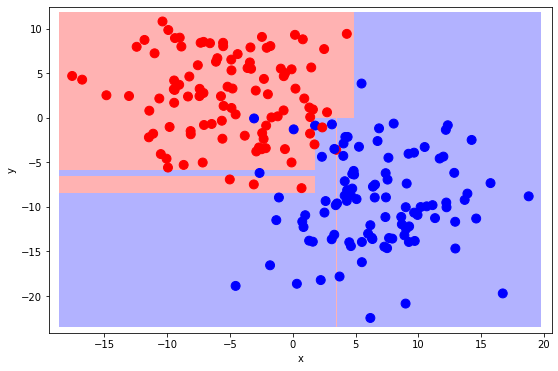

In [97]:
# Abbildung 4-30
tree4 = DecisionTreeClassifier(max_depth=4)
tree4.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree4, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=1000) # try predict_prob!


plt.xlabel('x')
plt.ylabel('y')

### Level 5

In [67]:
tree5 = DecisionTreeClassifier(max_depth=5)
tree5.fit(X, y)
print(tree5.score(X,y))

0.99


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

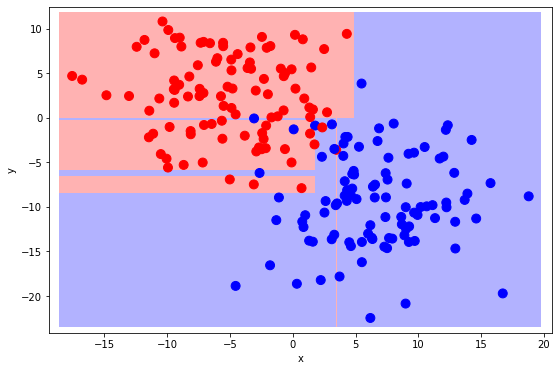

In [96]:
# Abbildung 4-31
tree5 = DecisionTreeClassifier(max_depth=5)
tree5.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree5, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=1000) # try predict_prob!

plt.xlabel('x')
plt.ylabel('y')

### vs Overfitting

Auf der vierten und fünften Ebene (siehe Abbildungen 4-29 und 4-30) kannst du aber ein Problem erkennen: Overfitting. Der Algorithmus konzentriert sich zu sehr auf Einzelbeispiele und verliert dadurch an Generalisierungsfähigkeiten. Wir erkennen das intuitiv daran, dass kleine Entscheidungsinseln oder -raster entstehen, die nur durch einzelne wenige Trainingsbeispiele verursacht werden.

Wir können Overfitting unterdrücken, wenn wir einige der Voreinstellungen ändern. Eine Möglichkeit ist, die maximale Anzahl der Ebenen anzugeben. Wenn wir in unserem Beispiel diese maximale Anzahl auf 5 festlegen, sehen die Entscheidungsflächen folgendermaßen aus (siehe Abbildung 4-32):

In [71]:
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=3,
                              min_samples_split=2)
tree.fit(X, y)
print(tree.score(X,y))

0.97


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

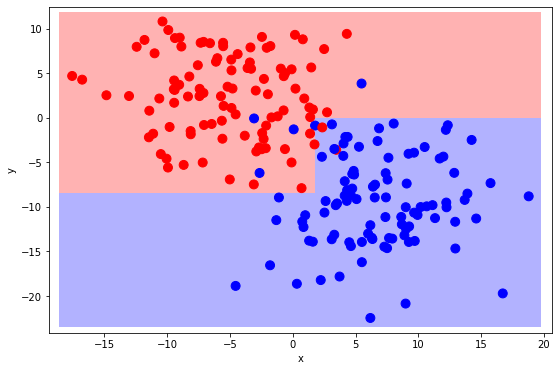

In [98]:
# Abbildung 4-32
tree5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=2)
tree5.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree5, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=1000) # try predict_prob!

plt.xlabel('x')
plt.ylabel('y')

Eine weitere Möglichkeit besteht darin, die Mindestanzahl von 10 Beispielen pro Verzweigung anzugeben (siehe Abbildung 4-33):

In [73]:
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=1,
                              min_samples_split=10)
tree.fit(X, y)
print(tree.score(X,y))

0.98


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

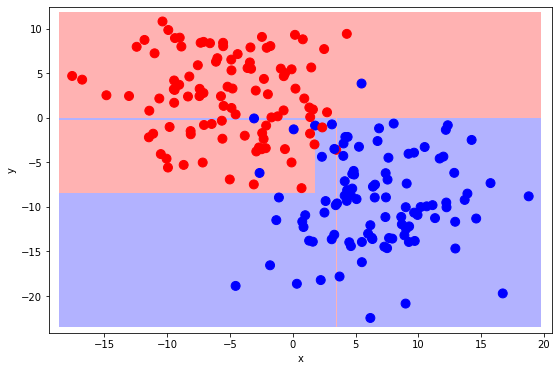

In [99]:
# Abbildung 4-33
tree5 = DecisionTreeClassifier(max_depth=5,min_samples_leaf=1,min_samples_split=10)
tree5.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree5, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=1000) # try predict_prob!

plt.xlabel('x')
plt.ylabel('y')

Die Festlegung der maximalen Anzahl von Blättern auf 8 führt zu folgendem Ergebnis (siehe Abbildung 4-34)

In [18]:
tree = DecisionTreeClassifier(max_depth=5,
                              min_samples_leaf=1,
                              min_samples_split=2,
                              max_leaf_nodes=8)
tree.fit(X, y)
print(tree.score(X,y))

0.98


Text(0, 0.5, 'y')

<Figure size 432x288 with 0 Axes>

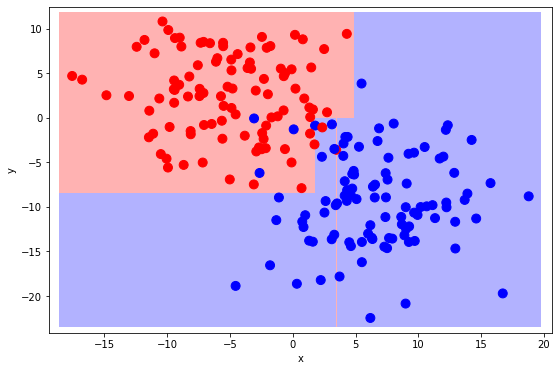

In [101]:
# Abbildung 4-34
tree5 = DecisionTreeClassifier(max_depth=5,min_samples_leaf=1,min_samples_split=2,max_leaf_nodes=8)
tree5.fit(X, y)

plt.clf()
fig = plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3)
ax.axis('tight')

disp = DecisionBoundaryDisplay.from_estimator(tree5, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=1000) # try predict_prob!

plt.xlabel('x')
plt.ylabel('y')

## Iris mit Decision Tree

In [23]:
# Lade den Irisdatensatz in X,y
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data, iris.target

In [25]:
# Trainiere einen Entscheidungsbaum auf den Daten mit sinnvoller Regularisierung
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    max_leaf_nodes=8
)
tree.fit(X, y)
tree.score(X,y)

0.9933333333333333

Das Resultat ist eine dreidimensionale Hyperebene im vierdimensionalen Feature-Raum. Diese können wir natürlich wieder nicht darstellen, deshalb zeigen wir dir die paarweisen zweidimensionalen Entscheidungsflächen in Abbildung 4-35. In diesem Fall gibt es sechs solcher Flächen. Sie stellen die Projektionen der dreidimensionalen Hyperfläche auf die jeweilige zweidimensionale Ebene dar. So bekommst du zumindest einen gewissen Eindruck der resultierenden
Hyperebene.

Wie schon in der Einleitung angedeutet, können Decision Trees sehr effektiv sein, aber sie tendieren leicht zu Overfitting. Eine Regularisierung mithilfe der vielen Parameter ist möglich, in der Praxis aber oft zu aufwendig. Weiter unten werden wir dir im Rahmen der Ensemble-Methoden auch die Random-Forest-Methode vorstellen, die einige dieser Probleme löst.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


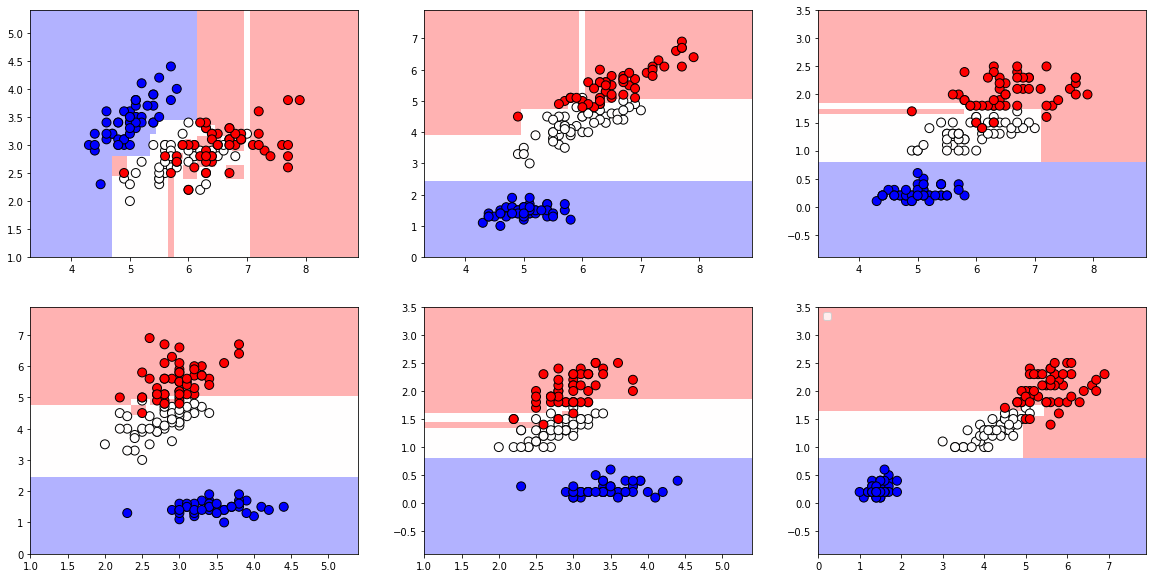

In [104]:
# Abbildung 4-35, Paarweise Entscheidungsflächen des Decision-Tree-Klassifikators für die Irisdaten
from sklearn.tree import DecisionTreeClassifier

n_classes = 3
colors = 'bwr' #['b','y','r']
CMAP = colors #plt.cm.rainbow
plot_step = 0.01

fig = plt.figure(1, figsize=(20, 10))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    clf = tree.fit(X, y)

    plt.subplot(2, 3, pairidx + 1)
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3, edgecolor="k")
    disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=1000) # try predict_prob!

    plt.axis("tight")

plt.legend(loc='upper left')
plt.show()


## Split-Kriterium: Gini Impurity vs. Entropy

Vorher aber sehen wir uns für ein besseres Verständnis in einem kleinen Exkurs an, wie auf jeder Ebene die Entscheidung getroffen
wird, auf welche Weise die Zweige aufgespaltet werden. Als Voreinstellung wird das **Gini-Kriterium** angewendet. Dieses Kriterium ist ein Maß für die Klasseninhomogenität (engl. Impurity) der Beispiele, die in einen Zweig fallen:

$$ \text{Gini} = 1 - \sum p(i)^2 $$

Dabei bezeichnen $i$ die Klasse und $p$ die Wahrscheinlichkeit einer Klasse (approximiert durch den relativen Anteil der Beispiele in
Klasse $i$). Je kleiner der Gini-Wert, desto größer ist die **Klassenhomogenität** des Splits. Teilt der Split die Beispiele für einen Zweig
nur in eine Klasse $i$ auf, wird die Wahrscheinlichkeit für Klasse $i$ 1 und 0 für alle anderen. Die Gini Impurity ist dann null. Sind aber
gleich viele Beispiele für alle Klassen i in dem Zweig, werden alle Wahrscheinlichkeiten klein und die Gini Impurity maximal.

![](images/gini.png)

Alternativ kannst du Entropie als Kriterium anwenden. Die Entropy ist definiert als
$$ \text{Entropie} = -\sum p(i) \cdot \log p(i) $$

Sie ist ebenfalls ein Maß für die Homogenität der Klassen. Sie hat ähnliche Eigenschaften wie die Gini Impurity, und man erhält in
der Praxis sehr ähnliche Ergebnisse mit beiden. Das Gini-Kriterium ist bei der Berechnung etwas schneller, da kein Logarithmus angewendet wird, und wird deshalb etwas häufiger benutzt.

Score for criterion entropy: 0.985
Score for criterion gini: 0.99


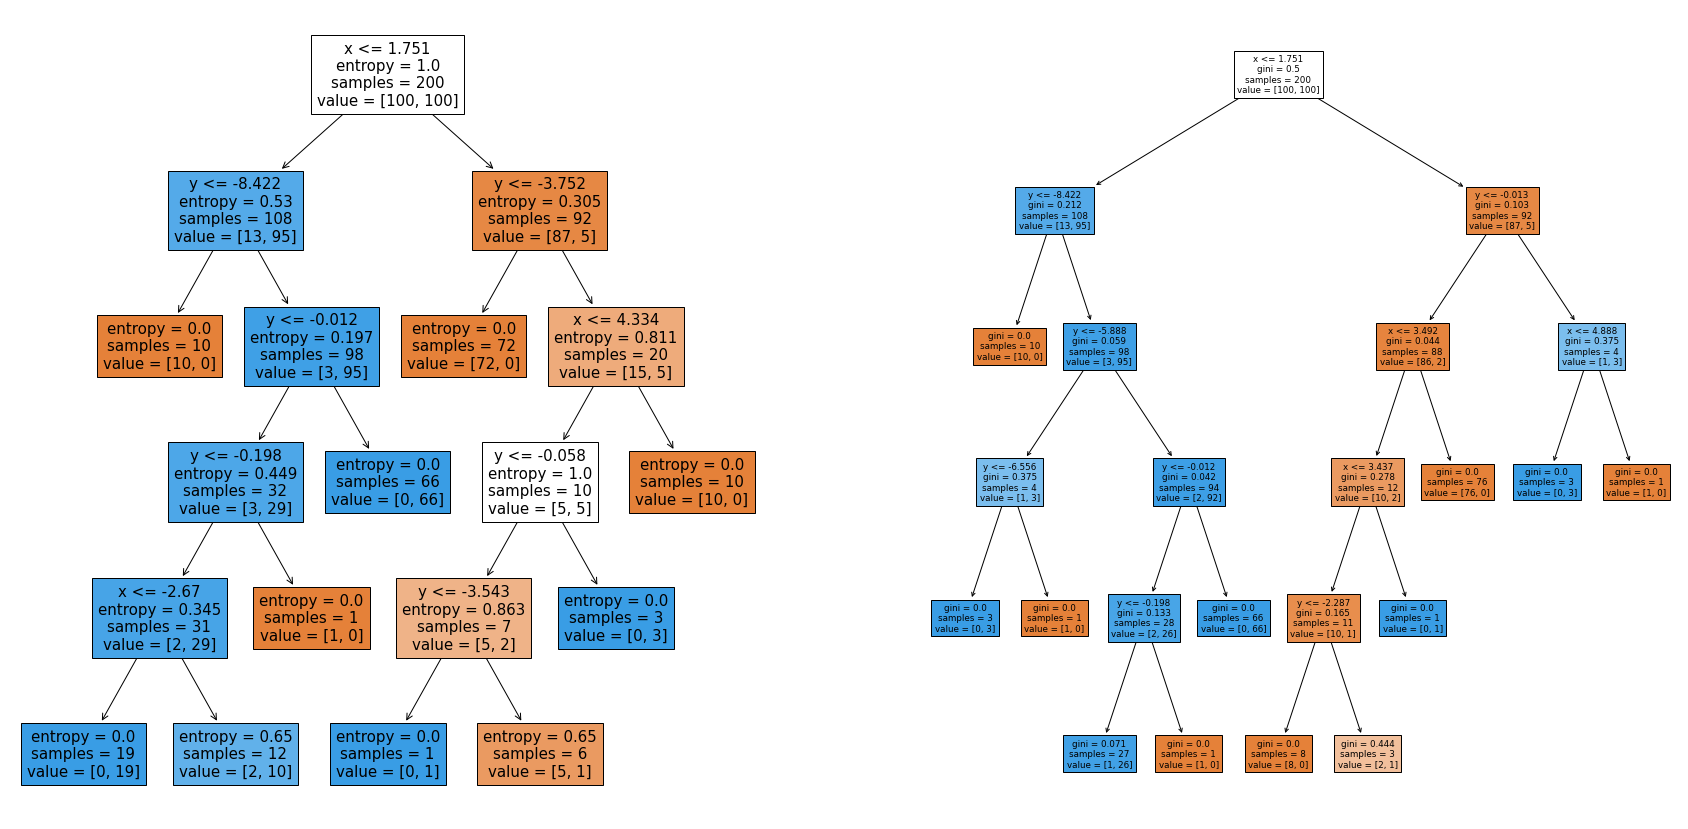

In [49]:
# Trainiere einen Baum bis Tiefe 5 einmal mit Entropy und einmal Gini Impurity
from sklearn.tree import DecisionTreeClassifier, plot_tree

fig, ax = plt.subplots(1,2, figsize=(30,15))

for i, criterion in enumerate(["entropy", "gini"]):
    tree5 = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=1,
        min_samples_split=2,
        max_leaf_nodes=None,
        criterion=criterion)
    tree5.fit(X, y)
    print(f"Score for criterion {criterion}: {tree5.score(X,y)}")
    plot_tree(tree5, filled=True, feature_names=["x", "y"], ax=ax[i])

## Bagging Methods - Random Forest Classifier

Ein großer Nachteil von Decision-Tree-Klassifikatoren ist das Overfitting. Wie wir im vorigen Abschnitt gesehen haben, kann man Overfitting unterdrücken, indem man verschiedene Regularisierungsparameter manuell einstellt. Die optimalen Parameter hängen aber nicht nur von den Features ab, sondern auch von der Anzahl der Trainingsbeispiele. Die Suche nach den optimalen Parametern oder eine Automatisierung ist in der Praxis häufig sehr umständlich und aufwendig.

Die Bagging-Methode des **Random Forest Classifier** ist ein Beispiel für eine **Ensemble-Methode**, die Overfitting reduzieren kann. Beim
Random-Forest-Klassifikator wird der Datensatz zunächst in kleinere zufällige Subsamples aufgeteilt (wobei Duplikate ausdrücklich erlaubt sind). Für jedes dieser Subsamples wird wiederum ein Decision Tree Classifier mit einem zufälligen Subsample der Features generiert. Die jeweiligen Ergebnisse werden am Ende mit gleicher Gewichtung zusammengefasst. Es wird bei Regression also der Durchschnitt aller Einzelentscheidungen für die Gesamtentscheidung genommen bzw. bei der Klassifikation die Mehrheit.

In der Voreinstellung in Sklearn werden zehn zufällige Klassifikatoren (`n_estimators`) generiert. Zusätzlich kann man auch noch die
Parameter der einzelnen Decision Trees einstellen (`max_depth` etc.)

In [54]:
# Initialisiere einen Random Forest Classifier von Sklearn
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Wenden wir den so initiierten Random Forest Classifier auf unsere Irisdaten an, erhalten wir folgendes Ergebnis:

In [56]:
# Anwenden auf Iris
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

rf.fit(X,y)
rf.score(X,y)

1.0

In [77]:
X = iris.data
y = iris.target

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X,y)
print(rf.score(X,y))

1.0


In Abbildung 4-36 wird der Klassifikator wieder als paarweise Entscheidungsflächen visualisiert.

0.9933333333333333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


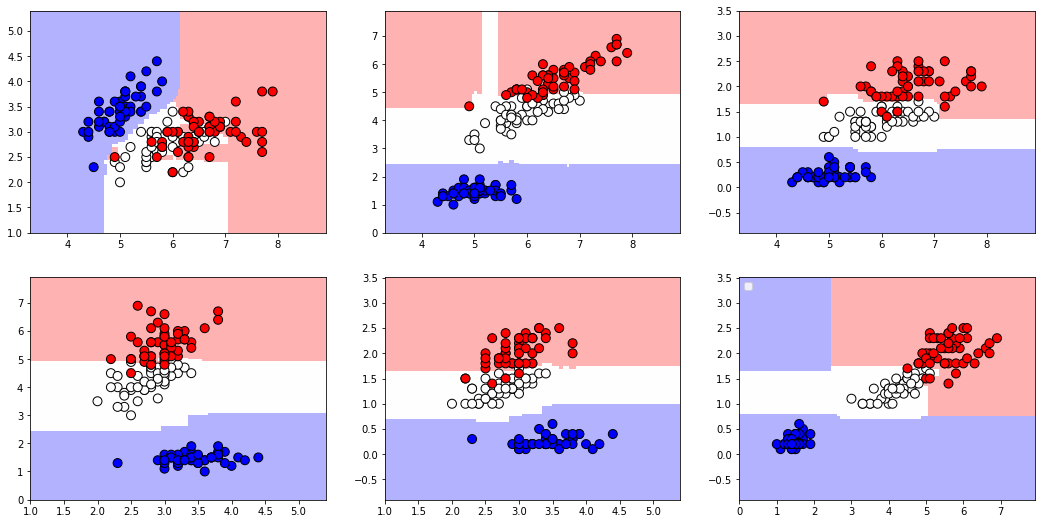

In [107]:
# Abbildung 4-36
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X,y)
print(rf.score(X,y))

# Visualisierung
n_classes = 3
colors = 'bwr' #['b','y','r']
CMAP = colors #plt.cm.rainbow
plot_step = 0.01

fig = plt.figure(1, figsize=(18, 9))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    clf = rf.fit(X, y)

    plt.subplot(2, 3, pairidx + 1)

    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3, edgecolor="k")
    disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=500) # try predict_prob!

    plt.axis("tight")

plt.legend(loc='upper left')
plt.show()

Random Forests haben in der Regel eine bessere Performance als einzelne Decision Trees. Sie neigen auch weniger zu Overfitting.
Ansonsten besitzen sie weiterhin alle Vorteile von Decision Trees, z.B. die Information über die Relevanz der einzelnen Features während des Trainings, und aufwendiges Preprocessing ist ebenfalls nicht notwendig.

## Boosted Decision Trees

Bei der Bagging-Methode oben werden die Ergebnisse von möglichst guten Einzelklassifikatoren zusammengefasst, um eine bessere Generalisierung zu erreichen. Im Gegensatz dazu versucht man mit der Boosting-Methode, viele verschiedene schwache Einzelklassifikatoren zu trainieren. Dabei geht man in der Regel iterativ vor. In jedem Iterationsschritt wird ein zufälliger schwacher Klassifikator hinzugenommen, und zusätzlich bekommen die missklassifizierten Trainingsbeispiele höhere Gewichte und die korrekt klassifizierten geringere. Sukzessive werden dadurch viele spezialisierte Klassifikatoren generiert, die kombiniert werden zu einem Gesamtklassifikator. Die Idee von Boosting ist es, Overfitting zu reduzieren, indem man viele schwache (nicht komplexe) Klassifikatoren, die jeder für sich overfitten, kombiniert.

Es gibt verschiedene Boosting-Algorithmen. Einer der bekanntesten ist der AdaBoost-Algorithmus, der auch in Sklearn benutzt werden kann:

In [59]:
# Wende AdaBoost-Algorithmus auf Iris-Datensatz an
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

iris = load_iris()
X = iris.data
y = iris.target

bdt = AdaBoostClassifier()
bdt.fit(X,y)
bdt.score(X,y)

0.96

In [61]:
bdt.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

0.96


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


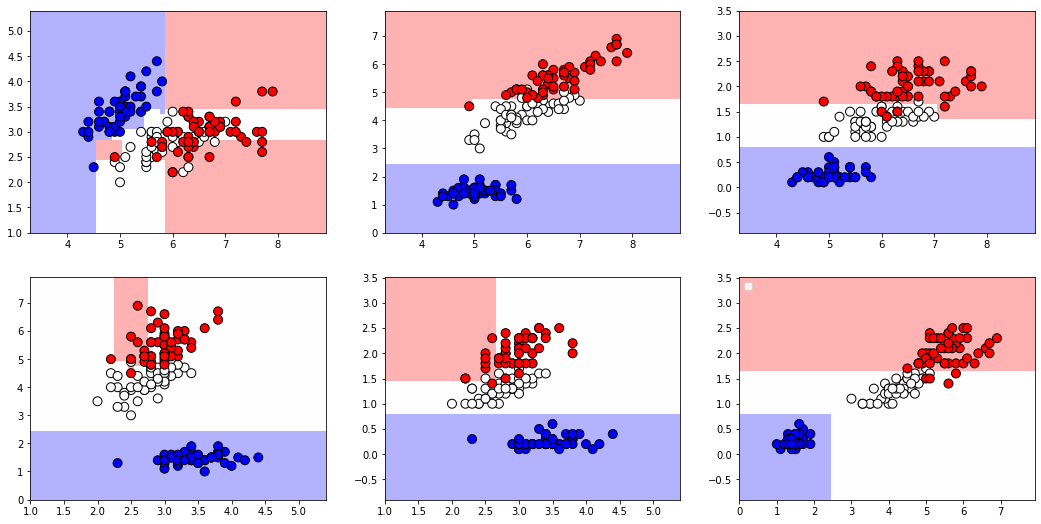

In [109]:
# Abbildung 4-37
from sklearn.ensemble import AdaBoostClassifier
bdt = AdaBoostClassifier()
bdt.fit(X,y)
print(bdt.score(X,y))

# Visualisierung
n_classes = 3
colors = 'bwr' #['b','y','r']
CMAP = colors #plt.cm.rainbow
plot_step = 0.01

fig = plt.figure(1, figsize=(18, 9))

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    X = iris.data[:, pair]
    y = iris.target

    clf = bdt.fit(X, y)

    plt.subplot(2, 3, pairidx + 1)

    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap=CMAP, clim=(y.min(), y.max()), zorder=3, edgecolor="k")
    disp = DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.3, ax=ax, cmap=CMAP, plot_method="pcolormesh", response_method="predict", grid_resolution=500) # try predict_prob!

    plt.axis("tight")

plt.legend(loc='upper left')
plt.show()

Boosted Decision Trees können bessere Ergebnisse liefern als Random Forests, wenn man die Parameter richtig anpasst. Das Tunen
der vielen Parameter ist wesentlich aufwendiger als bei Random Forests, und bessere Ergebnisse sind nicht garantiert. Ein Overtunen von Boosted Decision Trees führt leichter zu Overfitting.

## Classifier comparison

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
